# 1. Covid

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.diagnostic import acorr_ljungbox

## Data

/tmp/ipython-input-3715274958.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2015-01-01", end="2024-12-31")["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3715274958.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nikkei = yf.download("^N225", start="2015-01-01", end="2024-12-31")["Close"]
[*********************100%***********************]  1 of 1 completed


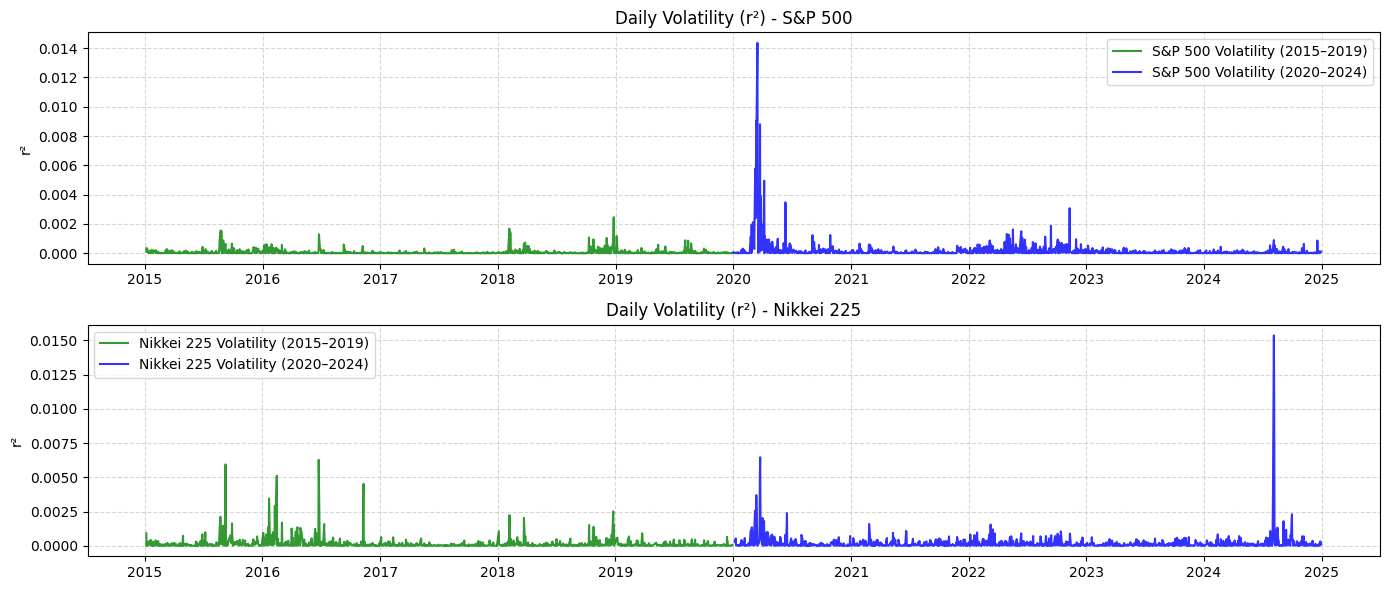

In [ ]:
# 1. Download data
sp500 = yf.download("^GSPC", start="2015-01-01", end="2024-12-31")["Close"]
nikkei = yf.download("^N225", start="2015-01-01", end="2024-12-31")["Close"]

# 2. Compute daily returns
r_sp = sp500.pct_change().dropna()
r_jp = nikkei.pct_change().dropna()

# 3. Volatility = squared returns
v_sp = r_sp**2
v_jp = r_jp**2

# 4. Split into pre- and post-COVID periods
sp_pre  = v_sp["2015":"2019"]
sp_post = v_sp["2020":"2024"]
jp_pre  = v_jp["2015":"2019"]
jp_post = v_jp["2020":"2024"]

# 5. Plot the volatility series
plt.figure(figsize=(14, 6))

# S&P 500
plt.subplot(2, 1, 1)
plt.plot(sp_pre, label="S&P 500 Volatility (2015–2019)", color="green", alpha=0.8)
plt.plot(sp_post, label="S&P 500 Volatility (2020–2024)", color="blue", alpha=0.8)
plt.title("Daily Volatility (r²) - S&P 500")
plt.legend()
plt.ylabel("r²")
plt.grid(True, linestyle="--", alpha=0.5)

# Nikkei 225
plt.subplot(2, 1, 2)
plt.plot(jp_pre, label="Nikkei 225 Volatility (2015–2019)", color="green", alpha=0.8)
plt.plot(jp_post, label="Nikkei 225 Volatility (2020–2024)", color="blue", alpha=0.8)
plt.title("Daily Volatility (r²) - Nikkei 225")
plt.legend()
plt.ylabel("r²")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## ACF graphs

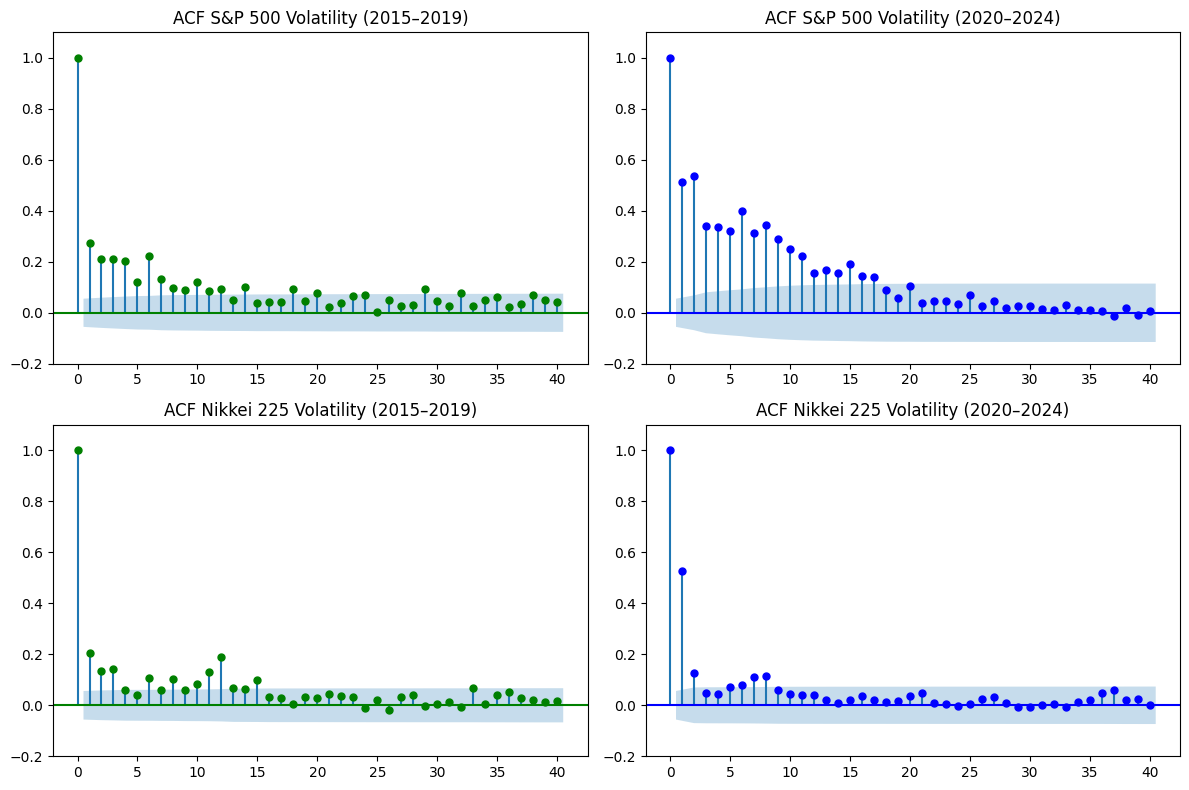

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# 1. Autocorrelation plots of volatility (r²)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# S&P 500 - pre and post COVID
plot_acf(sp_pre, lags=40, ax=axes[0, 0], color="green", title="ACF S&P 500 Volatility (2015–2019)")
axes[0, 0].set_ylim(-0.2, 1.1)

plot_acf(sp_post, lags=40, ax=axes[0, 1], color="blue", title="ACF S&P 500 Volatility (2020–2024)")
axes[0, 1].set_ylim(-0.2, 1.1)

# Nikkei 225 - pre and post COVID
plot_acf(jp_pre, lags=40, ax=axes[1, 0], color="green", title="ACF Nikkei 225 Volatility (2015–2019)")
axes[1, 0].set_ylim(-0.2, 1.1)

plot_acf(jp_post, lags=40, ax=axes[1, 1], color="blue", title="ACF Nikkei 225 Volatility (2020–2024)")
axes[1, 1].set_ylim(-0.2, 1.1)

plt.tight_layout()
plt.show()

## Test to check weakly stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch

for name, series in zip(
    ["S&P 500 Pre", "S&P 500 Post", "Nikkei 225 Pre", "Nikkei 225 Post"],
    [sp_pre, sp_post, jp_pre, jp_post]
):
    adf_stat, adf_p, *_ = adfuller(series)
    kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags='auto')

    print(f"{name:15s} | ADF p = {adf_p:6.4f} | KPSS p = {kpss_p:6.4f}")

/tmp/ipython-input-1675747567.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags='auto')


S&P 500 Pre     | ADF p = 0.0000 | KPSS p = 0.1000
S&P 500 Post    | ADF p = 0.0000 | KPSS p = 0.0215
Nikkei 225 Pre  | ADF p = 0.0000 | KPSS p = 0.0100
Nikkei 225 Post | ADF p = 0.0000 | KPSS p = 0.1000


/tmp/ipython-input-1675747567.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags='auto')
/tmp/ipython-input-1675747567.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags='auto')


## Testing Autocorrelation - Ljung–Box Test

In [ ]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

for name, series in zip(
    ["S&P 500 Pre", "S&P 500 Post", "Nikkei 225 Pre", "Nikkei 225 Post"],
    [sp_pre, sp_post, jp_pre, jp_post]
):
    lb = acorr_ljungbox(series, lags=[10], return_df=True)
    pval = lb["lb_pvalue"].iloc[0]
    stat = lb["lb_stat"].iloc[0]
    print(f"{name:15s} |  p-value = {pval:6.4f}")

S&P 500 Pre     |  p-value = 0.0000
S&P 500 Post    |  p-value = 0.0000
Nikkei 225 Pre  |  p-value = 0.0000
Nikkei 225 Post |  p-value = 0.0000


## Hypothesis testing

In [ ]:
from scipy.stats import norm

# 1. Newey-West
def newey_west_lrv(x, lag):
    x = np.asarray(x) - np.mean(x)
    n = len(x)
    gamma0 = np.var(x, ddof=0)
    lrv = gamma0
    for j in range(1, lag + 1):
        w = 1 - j / (lag + 1)  # Bartlett kernel
        cov = np.cov(x[:-j], x[j:], ddof=0)[0, 1]
        lrv += 2 * w * cov
    return lrv

# 2. HAC t-test
def hac_t_mean_diff(x, y, lag_x, lag_y):
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = len(x), len(y)
    mx, my = np.mean(x), np.mean(y)
    lrv_x = newey_west_lrv(x, lag_x)
    lrv_y = newey_west_lrv(y, lag_y)
    # Standard error
    se = np.sqrt(lrv_x / nx + lrv_y / ny)
    t_stat = (my - mx) / se
    # p-value
    p_val = 2 * (1 - norm.cdf(abs(t_stat)))

    return {
        "mean_x": mx,
        "mean_y": my,
        "mean_diff": my - mx,
        "t_stat": t_stat,
        "p_val": p_val,
        "lags": (lag_x, lag_y)
    }
tests = {
    "USA pre vs post":  (sp_pre, sp_post, 12, 22),
    "JPN pre vs post":  (jp_pre, jp_post, 15, 10),
    "pre: USA vs JPN":  (sp_pre, jp_pre, 12, 15),
    "post: USA vs JPN": (sp_post, jp_post, 22, 10),
}
for label, (a, b, lx, ly) in tests.items():
    res = hac_t_mean_diff(a, b, lag_x=lx, lag_y=ly)
    print(f"{label}: p-value = {res['p_val']:.4f}")

USA pre vs post: p-value = 0.0000
JPN pre vs post: p-value = 0.0836
pre: USA vs JPN: p-value = 0.0000
post: USA vs JPN: p-value = 0.7900


# 2. Estimating VaR

## Data

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from scipy.stats import jarque_bera, genpareto, genextreme, norm, kstest, beta, chi2
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [57]:
# 1. Load file
df = pd.read_excel("DATAout23.xlsx")

# 2. Take the last observation (closing price) of each day
df_daily = df.groupby("day", as_index=False).tail(1)

# 3. Compute daily log returns: r_t = log(P_t) - log(P_{t-1})
df_daily = df_daily.sort_values("day").reset_index(drop=True)
df_daily["ret"] = df_daily["logprice"].diff()
df_daily["loss"] = -df_daily["ret"]

# 4. Drop the first NaN (first day has no previous day to compare)
df_daily = df_daily.dropna(subset=["ret"])

# 5. Define returns and losses
ret = df_daily["ret"].values            # daily log returns
loss = -ret                             # losses as positive numbers
n_loss = len(loss)
n_ret = len(ret)
alpha_loss = 0.99                       # confidence level for returns
p_tail_loss = 1 - alpha_loss            # tail probability
alpha_ret = 0.01                        # confidence level for returns
p_tail_ret = 1 - alpha_ret              # tail probability
h = 1                                   # holding period

# Quick check
print(df_daily.head())
print(f"\nNumber of days: {len(df_daily)}")
print(f"Mean daily return: {ret.mean():.6f}")

   day      tick  logprice       ret      loss
1    2  0.999957  2.920470  0.009207 -0.009207
2    3  0.999957  2.921009  0.000539 -0.000539
3    4  0.999957  2.925846  0.004837 -0.004837
4    5  0.999915  2.936513  0.010667 -0.010667
5    6  0.999658  2.928524 -0.007989  0.007989

Number of days: 481
Mean daily return: 0.000767


### Graph of Daily Log Price

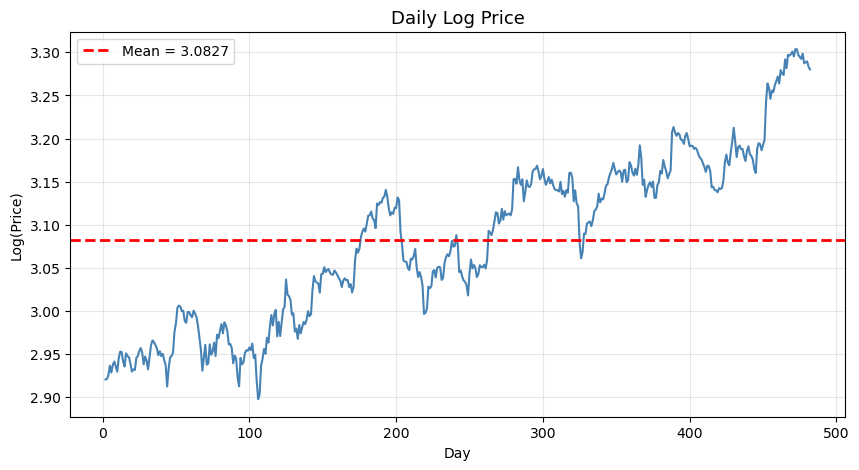

In [59]:
# 1. Compute the mean of the log prices
mean_logprice = df_daily["logprice"].mean()

# 2. Plot the time series of log prices
plt.figure(figsize=(10,5))
plt.plot(df_daily["day"], df_daily["logprice"], color='steelblue')
plt.axhline(y=mean_logprice, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_logprice:.4f}')
plt.title("Daily Log Price", fontsize=13)
plt.xlabel("Day")
plt.ylabel("Log(Price)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



### Graph of Daily Log Returns

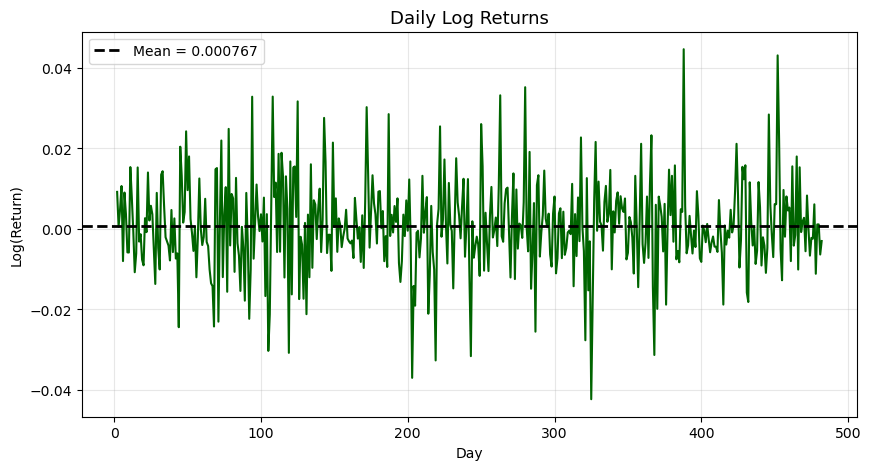

In [61]:
# 1. Compute the mean of the returns
mean_ret = df_daily["ret"].mean()

# 2. Plot the time series of log returns
plt.figure(figsize=(10,5))
plt.plot(df_daily["day"], df_daily["ret"], color='darkgreen')
plt.axhline(y=mean_ret, color='black', linestyle='--', linewidth=2, label=f'Mean = {mean_ret:.6f}')
plt.title("Daily Log Returns", fontsize=13)
plt.xlabel("Day")
plt.ylabel("Log(Return)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [63]:
from statsmodels.tsa.stattools import adfuller, kpss

# 1. ADF: H0 = not stationary
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(ret, autolag='AIC')
print("ADF stat:", adf_stat, "  p-value:", adf_p, "  crit:", adf_crit)

# 2. KPSS: H0 = stationary
kpss_stat, kpss_p, _, kpss_crit = kpss(ret, regression='c', nlags='auto')
print("KPSS stat:", kpss_stat, "  p-value:", kpss_p, "  crit:", kpss_crit)

ADF stat: -21.6670940216043   p-value: 0.0   crit: {'1%': -3.4440471158221206, '5%': -2.867580197120949, '10%': -2.5699871918402777}
KPSS stat: 0.025272157197311917   p-value: 0.1   crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\fatil\AppData\Local\Temp\ipykernel_28128\739180066.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(ret, regression='c', nlags='auto')


### Graph of Daily Log Losses

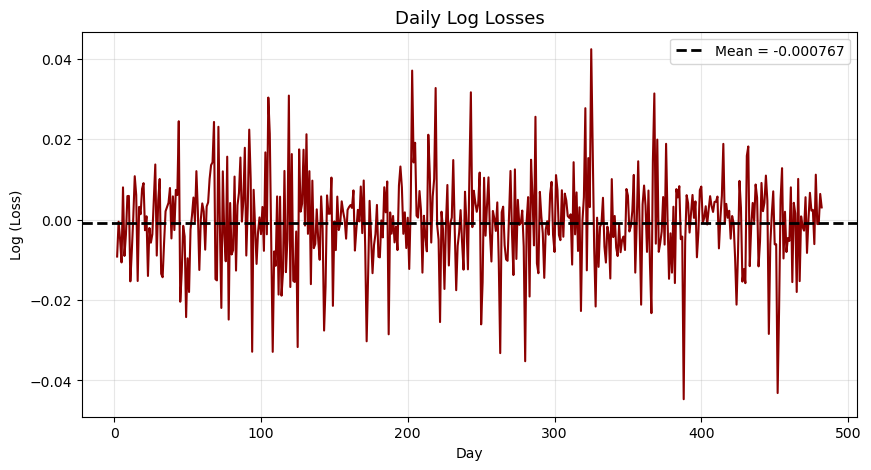

In [65]:
# 1. Compute daily losses (positive for losses)
mean_loss = df_daily["loss"].mean()

# 2. Plot the time series of log losses
plt.figure(figsize=(10,5))
plt.plot(df_daily["day"], df_daily["loss"], color='darkred')
plt.axhline(y=mean_loss, color='black', linestyle='--', linewidth=2, label=f'Mean = {mean_loss:.6f}')
plt.title("Daily Log Losses", fontsize=13)
plt.xlabel("Day")
plt.ylabel("Log (Loss)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [67]:
from statsmodels.tsa.stattools import adfuller, kpss

# 1. ADF: H0 = not stationary
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(loss, autolag='AIC')
print("ADF stat:", adf_stat, "  p-value:", adf_p, "  crit:", adf_crit)

# 2. KPSS: H0 = stationary
kpss_stat, kpss_p, _, kpss_crit = kpss(loss, regression='c', nlags='auto')
print("KPSS stat:", kpss_stat, "  p-value:", kpss_p, "  crit:", kpss_crit)

ADF stat: -21.6670940216043   p-value: 0.0   crit: {'1%': -3.4440471158221206, '5%': -2.867580197120949, '10%': -2.5699871918402777}
KPSS stat: 0.025272157197311917   p-value: 0.1   crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\fatil\AppData\Local\Temp\ipykernel_28128\2479511551.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(loss, regression='c', nlags='auto')


## 2.1. Parametric method

### Value-at-Risk

In [141]:
# 1. MLE estimates under normality
mu_hat = 0
sigma_hat = np.sqrt(np.mean((loss - mu_hat)**2))
z_alpha = norm.ppf(alpha_loss)

# 2. Gaussian VaR
VaR_param = mu_hat + z_alpha * sigma_hat * np.sqrt(h)

# 3. Confidence Interval - CHI
gamma = 0.05
sigma_lower = sigma_hat * np.sqrt(n_loss / chi2.ppf(1 - gamma/2, n_loss))
sigma_upper = sigma_hat * np.sqrt(n_loss / chi2.ppf(gamma/2, n_loss))
VaR_lower = mu_hat + z_alpha * sigma_lower
VaR_upper = mu_hat + z_alpha * sigma_upper

print(f"α = {alpha_loss:.2f}, z_α = {z_alpha:.4f}, σ̂ = {sigma_hat:.6f}")
print(f"σ̂ = {sigma_hat:.6f}")
print(f"\nVaR_Gaussian = {VaR_param:.6f}")
print(f"95% CI: [{VaR_lower:.6f}, {VaR_upper:.6f}]")

α = 0.99, z_α = 2.3263, σ̂ = 0.011421
σ̂ = 0.011421

VaR_Gaussian = 0.026569
95% CI: [0.024991, 0.028361]


### Value-at-Risk Filtered

In [143]:
# MLE estimates under normality
mu_hat = 0
sigma_hat = np.sqrt(np.mean((loss - mu_hat)**2))
z_alpha = norm.ppf(alpha_loss)
gamma = 0.05

# 1. Exponential smoothing
smoother = SimpleExpSmoothing(np.abs(ret))
fit_smooth = smoother.fit(smoothing_level=0.05, optimized=False)
vol_smooth = np.maximum(fit_smooth.fittedvalues, 1e-12)

# 2. Filtered losses
z_loss = loss / vol_smooth

# 3. Estimate mean and volatility of filtered losses
mu_hat_z = np.mean(z_loss)
sigma_hat_z = np.std(z_loss, ddof=1)

# 4. Forecast next-period volatility
sigma_next = vol_smooth[-1]

# 5. VaR
VaR_param_F = (mu_hat_z + z_alpha * sigma_hat_z) * sigma_next

# 6. Confidence Interval - CHI
n_z = len(z_loss)
sigma_lower_z = sigma_hat_z * np.sqrt(n_z / chi2.ppf(1 - gamma/2, n_z))
sigma_upper_z = sigma_hat_z * np.sqrt(n_z / chi2.ppf(gamma/2, n_z))

VaR_lower_F = (mu_hat_z + z_alpha * sigma_lower_z) * sigma_next
VaR_upper_F = (mu_hat_z + z_alpha * sigma_upper_z) * sigma_next

print(f"μ_z = {mu_hat_z:.6f}, σ_z = {sigma_hat_z:.6f}")
print(f"σ_forecast(T+1) = {sigma_next:.6f}")
print(f"VaR_Gaussian_Filtered = {VaR_param_F:.6f}")
print(f"95% CI: [{VaR_lower_F:.6f}, {VaR_upper_F:.6f}]\n")

μ_z = -0.081451, σ_z = 1.375536
σ_forecast(T+1) = 0.006764
VaR_Gaussian_Filtered = 0.021094
95% CI: [0.019809, 0.022555]



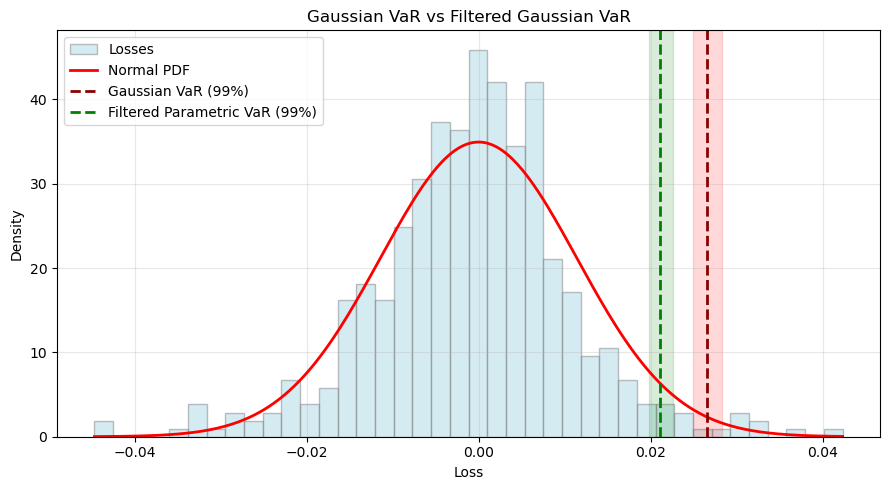

In [147]:
plt.figure(figsize=(9, 5))

x = np.linspace(min(loss), max(loss), 300)
pdf_norm = norm.pdf(x, loc=mu_hat, scale=sigma_hat)

plt.hist(loss, bins=40, density=True, alpha=0.5,
         color="lightblue", edgecolor="gray", label="Losses")

plt.plot(x, pdf_norm, 'r-', lw=2, label="Normal PDF")

plt.axvline(VaR_param, color="darkred", linestyle="--", lw=2,
            label=f"Gaussian VaR ({alpha_loss*100:.0f}%)")

plt.axvline(VaR_param_F, color="green", linestyle="--", lw=2,
            label=f"Filtered Parametric VaR ({alpha_loss*100:.0f}%)")

plt.axvspan(VaR_lower, VaR_upper, color="red", alpha=0.15)
plt.axvspan(VaR_lower_F, VaR_upper_F, color="green", alpha=0.15)

plt.title("Gaussian VaR vs Filtered Gaussian VaR")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2.2. Nonparametric method

### Value-at-Risk

In [151]:
# 1. Sort the loss sample in ascending order
sorted_losses = np.sort(loss)

# 2. Compute the theoretical position of the (1 - α) quantile
position = n_loss * (1-alpha_loss)
print(f"Theoretical position for quantile (1 - α): {position:.4f}")

# 3. Take the integer part (floor) of that position.
q = int(np.floor(position))

# 4. VaR
if q < n_loss - 1:
  # linear interpolation between order statistics
  VaR_hist = sorted_losses[q] + (position - q) * (sorted_losses[q+1] - sorted_losses[q])
else:
  VaR_hist = sorted_losses[-1]

sorted_losses = np.sort(loss)
k = int(np.floor(alpha_loss * n_loss))
VaR_hist = sorted_losses[k]

# 5. Confidence Interval - BETA
gamma = 0.05
p_lower = beta.ppf(gamma/2, k, n_loss + 1 - k)
p_upper = beta.ppf(1 - gamma/2, k, n_loss + 1 - k)
VaR_lower = np.quantile(sorted_losses, p_lower)
VaR_upper = np.quantile(sorted_losses, p_upper)

print(f"α = {alpha_loss:.2f}")
print(f"VaR_Historical = {VaR_hist:.6f}")
print(f"95% CI: [{VaR_lower:.6f}, {VaR_upper:.6f}]")

Theoretical position for quantile (1 - α): 4.8100
α = 0.99
VaR_Historical = 0.031332
95% CI: [0.022651, 0.032469]


### Value-at-Risk Filtered

In [155]:
# 1. Exponential smoothing
smoother = SimpleExpSmoothing(np.abs(ret))
fit_smooth = smoother.fit(smoothing_level=0.05, optimized=False)
vol_smooth = np.maximum(fit_smooth.fittedvalues, 1e-12)  # avoid division by zero

# 2. Filtered losses
z_loss = loss / vol_smooth

# 3. Empirical quantile
sorted_z = np.sort(z_loss)
position_z = n_loss * alpha_loss
qz = int(np.floor(position_z))

if qz < n_loss - 1:
    VaR_z = sorted_z[qz] + (position_z - qz) * (sorted_z[qz + 1] - sorted_z[qz])
else:
    VaR_z = sorted_z[-1]

# 4. Forecast next-period volatility
sigma_next = vol_smooth[-1]

# 5. VaR
VaR_FHS = VaR_z * sigma_next

# 6. Confidence interval - BETA
p_lower_z = beta.ppf(gamma / 2, qz, n_loss + 1 - qz)
p_upper_z = beta.ppf(1 - gamma / 2, qz, n_loss + 1 - qz)
VaR_lower_z = np.quantile(sorted_z, p_lower_z)
VaR_upper_z = np.quantile(sorted_z, p_upper_z)
VaR_lower_FHS = VaR_lower_z * sigma_next
VaR_upper_FHS = VaR_upper_z * sigma_next

print(f"σ_forecast (T+1) = {sigma_next:.6f}")
print(f"VaR_z (filtered) = {VaR_z:.6f}")
print(f"VaR_Historical_Filtered = {VaR_FHS:.6f}")
print(f"95% CI: [{VaR_lower_FHS:.6f}, {VaR_upper_FHS:.6f}]\n")

σ_forecast (T+1) = 0.006764
VaR_z (filtered) = 3.885428
VaR_Historical_Filtered = 0.026282
95% CI: [0.018414, 0.026672]



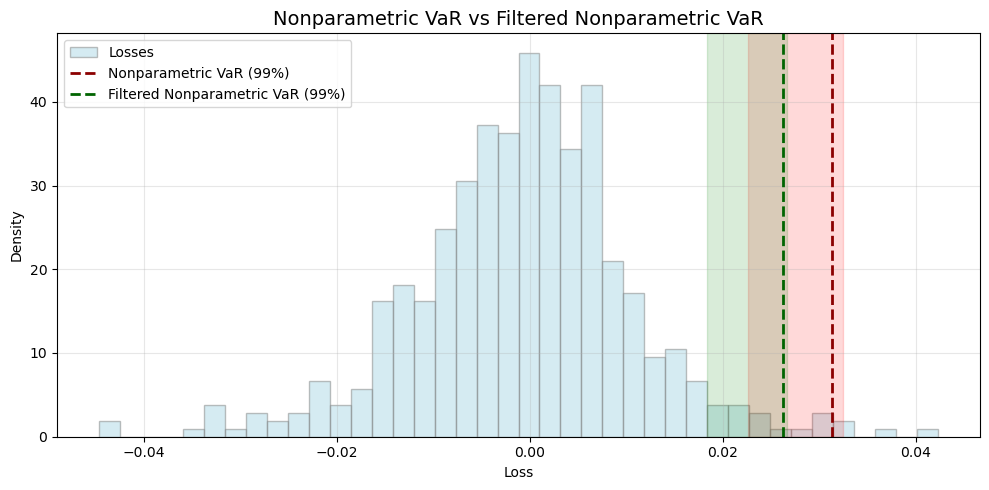

In [157]:
plt.figure(figsize=(10, 5))

# Histogram of losses
plt.hist(loss, bins=40, density=True, alpha=0.5, color="lightblue",
         edgecolor="gray", label="Losses")

# 1. Historical VaR
plt.axvline(VaR_hist, color='darkred', linestyle='--', lw=2,
            label=f"Nonparametric VaR ({alpha_loss*100:.0f}%)")
plt.axvspan(VaR_lower, VaR_upper, color="red", alpha=0.15)

# 2. Filtered Historical VaR 
plt.axvline(VaR_FHS, color='darkgreen', linestyle='--', lw=2,
            label=f"Filtered Nonparametric VaR ({alpha_loss*100:.0f}%)")
plt.axvspan(VaR_lower_FHS, VaR_upper_FHS, color="green", alpha=0.15)
plt.title("Nonparametric VaR vs Filtered Nonparametric VaR", fontsize=14)
plt.xlabel("Loss")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2.3. Extreme Value Theory

### 2.3.1. Block maxima - GEV

#### Value-at-Risk

In [176]:
from scipy.stats import genextreme

# 1. Define the blocks
block_size = 20   # 20 trading days ~ 1 month
blocks = [loss[i:i+block_size] for i in range(0, len(loss), block_size)]
block_maxima = np.array([b.max() for b in blocks if len(b) == block_size])

print(f"Number of complete blocks: {len(block_maxima)}")

# 2. Estimate GEV - MLE
shape_hat, loc_hat, scale_hat = genextreme.fit(block_maxima)
print(f"GEV parameters: shape={shape_hat:.4f}, loc={loc_hat:.4f}, scale={scale_hat:.4f}")

# 3. Adjust alpha for GEV
alpha_gev = 1.0 - block_size * (1 - alpha_loss)
print(f"Equivalent GEV confidence level: alpha_GEV = {alpha_gev:.4f}")

# 4. VaR
VaR_gev = genextreme.ppf(alpha_gev, shape_hat, loc=loc_hat, scale=scale_hat)
print(f"VaR_GEV: {VaR_gev:.6f}")

# 5. Confidence Interval - BOOTSTRAP
np.random.seed(123)
n_boot = 1000
VaR_boot = []

for _ in range(n_boot):
    sim_data = genextreme.rvs(shape_hat, loc=loc_hat, scale=scale_hat, size=len(block_maxima))
    sh, lo, sc = genextreme.fit(sim_data)
    VaR_boot.append(genextreme.ppf(alpha_gev, sh, loc=lo, scale=sc))

VaR_boot = np.array(VaR_boot)

# IC 95%
VaR_lower, VaR_upper = np.percentile(VaR_boot, [2.5, 97.5])
print(f"95% CI: [{VaR_lower:.6f}, {VaR_upper:.6f}]")

Number of complete blocks: 24
GEV parameters: shape=-0.7630, loc=0.0142, scale=0.0065
Equivalent GEV confidence level: alpha_GEV = 0.8000
VaR_GEV: 0.032378
95% CI: [0.021923, 0.053902]


#### Model diagnostics

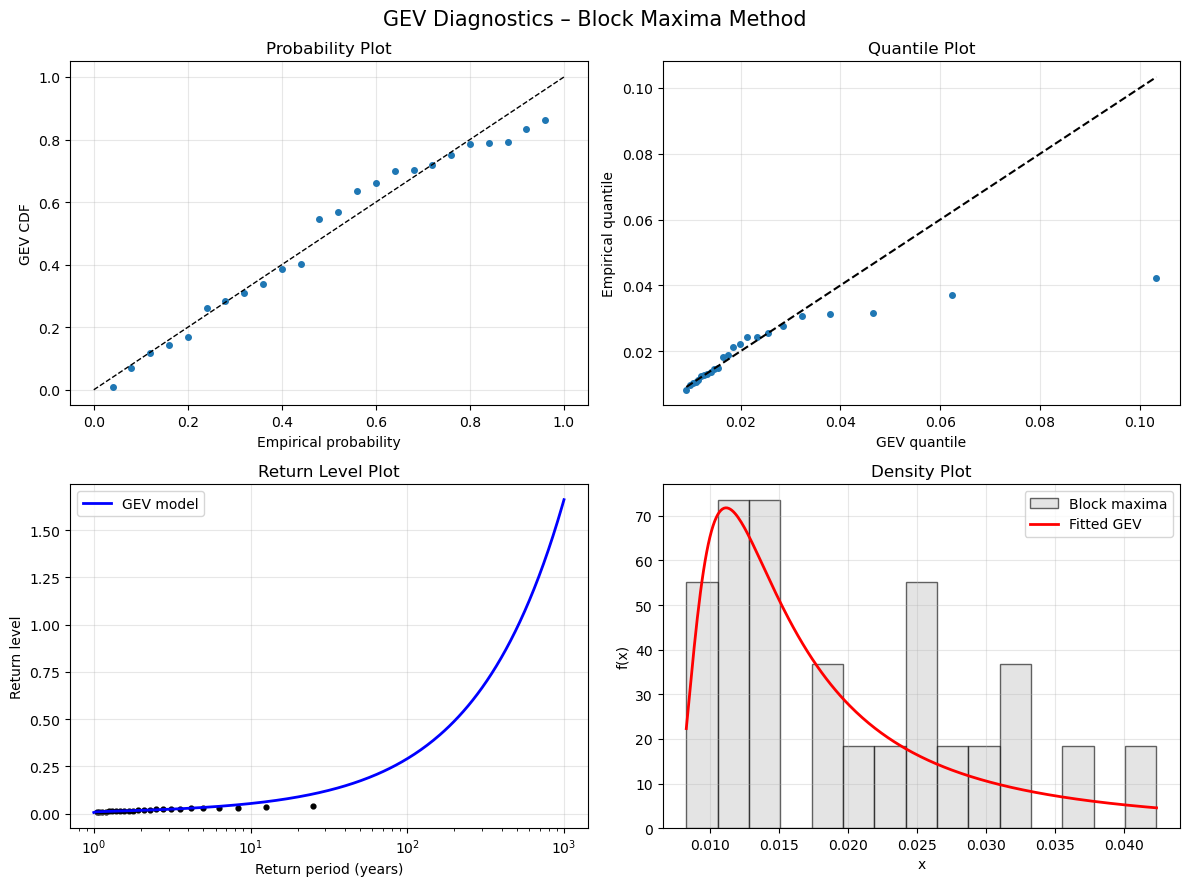

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

# 1. BLOCK MAXIMA
block_size = 20   # ≈ monthly maxima
blocks = [loss[i:i+block_size] for i in range(0, len(loss), block_size)]
block_maxima = np.array([b.max() for b in blocks if len(b) == block_size])
block_maxima_sorted = np.sort(block_maxima)
n = len(block_maxima)

# 2. FIT GEV (MLE)
shape_hat, loc_hat, scale_hat = genextreme.fit(block_maxima)

# Correct EVT empirical probabilities
p = np.arange(1, n+1) / (n + 1)

# CDF values
gev_cdf = genextreme.cdf(block_maxima_sorted, shape_hat, loc=loc_hat, scale=scale_hat)

# Theoretical quantiles for QQ-plot
theoretical_q = genextreme.ppf(p, shape_hat, loc=loc_hat, scale=scale_hat)

# 3. Return-Level Plot
return_periods = np.logspace(0, 3, 300)    # T = 1 to 1000
F = 1 - 1 / return_periods
return_levels = genextreme.ppf(F, shape_hat, loc=loc_hat, scale=scale_hat)

empirical_return_periods = 1 / (1 - p)

# 4. Density for Block Maxima

x = np.linspace(min(block_maxima), max(block_maxima), 300)
pdf = genextreme.pdf(x, shape_hat, loc=loc_hat, scale=scale_hat)

# 5. Graph

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# --- Probability Plot ---
axs[0, 0].plot(p, gev_cdf, "o", markersize=4)
axs[0, 0].plot([0,1], [0,1], "k--", lw=1)
axs[0, 0].set_title("Probability Plot")
axs[0, 0].set_xlabel("Empirical probability")
axs[0, 0].set_ylabel("GEV CDF")
axs[0, 0].grid(alpha=0.3)

# --- Quantile Plot ---
axs[0, 1].plot(theoretical_q, block_maxima_sorted, "o", markersize=4)
axs[0, 1].plot([min(theoretical_q), max(theoretical_q)],
               [min(theoretical_q), max(theoretical_q)], "k--")
axs[0, 1].set_title("Quantile Plot")
axs[0, 1].set_xlabel("GEV quantile")
axs[0, 1].set_ylabel("Empirical quantile")
axs[0, 1].grid(alpha=0.3)

# --- Return-Level Plot ---
axs[1, 0].plot(return_periods, return_levels, "b-", lw=2, label="GEV model")
axs[1, 0].scatter(empirical_return_periods, block_maxima_sorted, color="black", s=12)
axs[1, 0].set_xscale("log")
axs[1, 0].set_title("Return Level Plot")
axs[1, 0].set_xlabel("Return period (years)")
axs[1, 0].set_ylabel("Return level")
axs[1, 0].grid(alpha=0.3)
axs[1, 0].legend()

# --- Density Plot ---
axs[1, 1].hist(block_maxima, bins=15, density=True, alpha=0.6,
               color="lightgray", edgecolor="black", label="Block maxima")
axs[1, 1].plot(x, pdf, "r-", lw=2, label="Fitted GEV")
axs[1, 1].set_title("Density Plot")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("f(x)")
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

plt.suptitle("GEV Diagnostics – Block Maxima Method", fontsize=15)
plt.tight_layout()
plt.show()

#### Value-at-Risk Filtered

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 1. Exponential smoothing
smoother = SimpleExpSmoothing(np.abs(ret))
fit_smooth = smoother.fit(smoothing_level=0.05, optimized=False)
vol_smooth = np.maximum(fit_smooth.fittedvalues, 1e-12)

# 2. Filtered losses
z_loss = loss / vol_smooth

# 3. Divide z_loss into blocks and take filtered maxima
block_size = 20  
blocks_z = [z_loss[i:i+block_size] for i in range(0, len(z_loss), block_size)]
block_maxima_z = np.array([b.max() for b in blocks_z if len(b) == block_size])

print(f"Number of complete filtered blocks: {len(block_maxima_z)}")

# 4. Fit GEV distribution
shape_hat_z, loc_hat_z, scale_hat_z = genextreme.fit(block_maxima_z)

# 5. Equivalent confidence level for GEV
alpha_gev = 1.0 - block_size * (1 - alpha_loss)

# 6. VaR
VaR_z = genextreme.ppf(alpha_gev, shape_hat_z, loc=loc_hat_z, scale=scale_hat_z)
print(f"VaR_z (Filtered): {VaR_z:.6f}")

# 5. Confidence Interval
np.random.seed(123)
n_boot = 1000
VaR_boot_z = []

for _ in range(n_boot):
    sim_data_z = genextreme.rvs(shape_hat_z, loc=loc_hat_z, scale=scale_hat_z, size=len(block_maxima_z))
    sh, lo, sc = genextreme.fit(sim_data_z)
    VaR_boot_z.append(genextreme.ppf(alpha_gev, sh, loc=lo, scale=sc))
VaR_boot_z = np.array(VaR_boot_z)
VaR_lower_z, VaR_upper_z = np.percentile(VaR_boot_z, [2.5, 97.5])

sigma_next = vol_smooth[-1]
VaR_F_GEV = VaR_z * sigma_next
VaR_lower_F = VaR_lower_z * sigma_next
VaR_upper_F = VaR_upper_z * sigma_next

print(f"\nσ_forecast(T+1) = {sigma_next:.6f}")
print(f"VaR_GEV_Filtered = {VaR_F_GEV:.6f}")
print(f"95% CI: [{VaR_lower_F:.6f}, {VaR_upper_F:.6f}]\n")

Number of complete filtered blocks: 24
VaR_z (Filtered): 3.369849

σ_forecast(T+1) = 0.006764
VaR_GEV_Filtered = 0.022794
95% CI: [0.017710, 0.028204]



### Model diagnostics

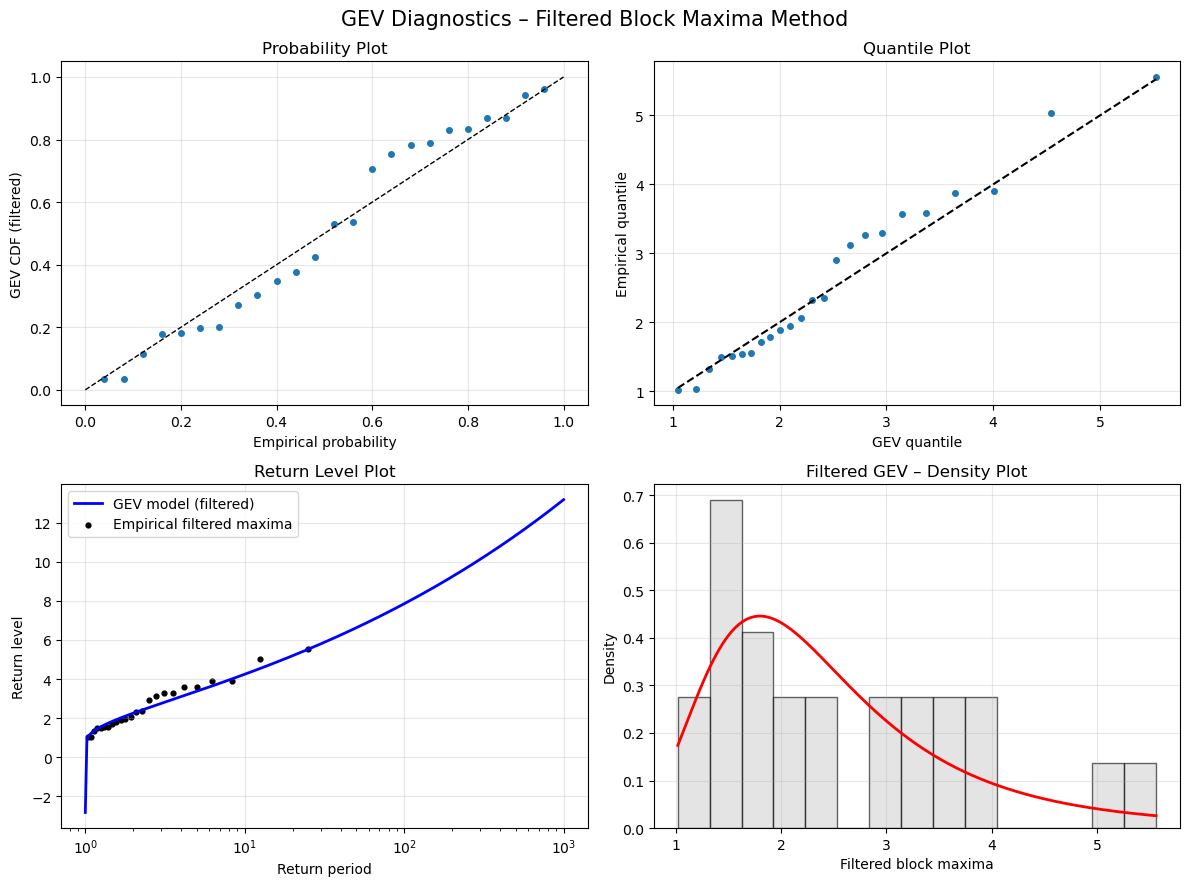

In [166]:
# 1. BLOCK MAXIMA
block_maxima_sorted_z = np.sort(block_maxima_z)
n_z = len(block_maxima_z)

# Empirical probabilities
p_z = np.arange(1, n_z + 1) / (n_z + 1)

# GEV CDF values
gev_cdf_z = genextreme.cdf(block_maxima_sorted_z,
                           shape_hat_z, loc=loc_hat_z, scale=scale_hat_z)

# Theoretical quantiles
theoretical_q_z = genextreme.ppf(p_z,
                                 shape_hat_z, loc=loc_hat_z, scale=scale_hat_z)

# Return levels
return_periods = np.logspace(0, 3, 300)   # T = 1 to 1000
F_z = 1 - 1 / return_periods
return_levels_z = genextreme.ppf(F_z,
                                 shape_hat_z, loc=loc_hat_z, scale=scale_hat_z)

empirical_return_periods_z = 1 / (1 - p_z)

# Density for plot
x = np.linspace(min(block_maxima_z), max(block_maxima_z), 300)
pdf_z = genextreme.pdf(x, shape_hat_z, loc=loc_hat_z, scale=scale_hat_z)

# PLOT
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# --- Probability Plot ---
axs[0, 0].plot(p_z, gev_cdf_z, "o", markersize=4)
axs[0, 0].plot([0,1], [0,1], "k--", lw=1)
axs[0, 0].set_title("Probability Plot")
axs[0, 0].set_xlabel("Empirical probability")
axs[0, 0].set_ylabel("GEV CDF (filtered)")
axs[0, 0].grid(alpha=0.3)

# --- Quantile Plot ---
axs[0, 1].plot(theoretical_q_z, block_maxima_sorted_z, "o", markersize=4)
axs[0, 1].plot([min(theoretical_q_z), max(theoretical_q_z)],
               [min(theoretical_q_z), max(theoretical_q_z)], "k--")
axs[0, 1].set_title("Quantile Plot")
axs[0, 1].set_xlabel("GEV quantile")
axs[0, 1].set_ylabel("Empirical quantile")
axs[0, 1].grid(alpha=0.3)

# --- Return-Level Plot ---
axs[1, 0].plot(return_periods, return_levels_z, "b-", lw=2, label="GEV model (filtered)")
axs[1, 0].scatter(empirical_return_periods_z, block_maxima_sorted_z,
                  color="black", s=12, label="Empirical filtered maxima")
axs[1, 0].set_xscale("log")
axs[1, 0].set_title("Return Level Plot")
axs[1, 0].set_xlabel("Return period")
axs[1, 0].set_ylabel("Return level")
axs[1, 0].grid(alpha=0.3)
axs[1, 0].legend()

# --- Density Plot ---
axs[1, 1].hist(block_maxima_z, bins=15, density=True, alpha=0.6,
               color="lightgray", edgecolor="black", label="Filtered block maxima")
axs[1, 1].plot(x, pdf_z, "r-", lw=2, label="Fitted GEV")
axs[1, 1].set_title("Filtered GEV – Density Plot")
axs[1, 1].set_xlabel("Filtered block maxima")
axs[1, 1].set_ylabel("Density")
axs[1, 1].grid(alpha=0.3)

plt.suptitle("GEV Diagnostics – Filtered Block Maxima Method", fontsize=15)
plt.tight_layout()
plt.show()

### 2.3.2. POT - GPD

#### Mean residual life plot

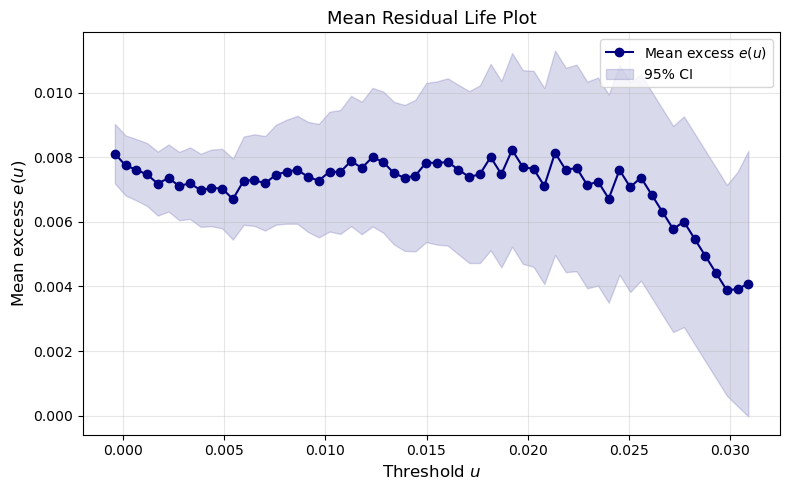

In [103]:
# 1. Define MRL
def mean_excess_ci(y, thresholds):
    """
    Returns e(u), lower(u), upper(u), n_u for each threshold.
    """
    e_vals, ci_lower, ci_upper, n_exc = [], [], [], []
    for u in thresholds:
        exceed = y[y > u]
        n_u = len(exceed)
        if n_u > 1:
            excesses = exceed - u
            e_u = np.mean(excesses)
            s_u = np.std(excesses, ddof=1)
            se_u = s_u / np.sqrt(n_u)
            ci_l = e_u - 1.96 * se_u
            ci_u = e_u + 1.96 * se_u

            e_vals.append(e_u)
            ci_lower.append(ci_l)
            ci_upper.append(ci_u)
            n_exc.append(n_u)
        else:
            e_vals.append(np.nan)
            ci_lower.append(np.nan)
            ci_upper.append(np.nan)
            n_exc.append(n_u)

    return (np.array(e_vals),
            np.array(ci_lower),
            np.array(ci_upper),
            np.array(n_exc))

# 2. Compute points + confidence intervals
u_min, u_max = np.percentile(loss, 50), np.percentile(loss, 99)  # threshold range
thresholds = np.linspace(u_min, u_max, 60)  # 60 values between P50 and P99
e_vals, ci_l, ci_u, n_exc = mean_excess_ci(loss, thresholds)

# 3. Plot
plt.figure(figsize=(8,5))

# Mean excess
plt.plot(thresholds, e_vals, 'o-', color='navy', label='Mean excess $e(u)$')

# Confidence interval (bands)
plt.fill_between(thresholds, ci_l, ci_u,
                 color='navy', alpha=0.15, label='95% CI')

plt.xlabel('Threshold $u$', fontsize=12)
plt.ylabel('Mean excess $e(u)$', fontsize=12)
plt.title('Mean Residual Life Plot', fontsize=13)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### Parameters stability

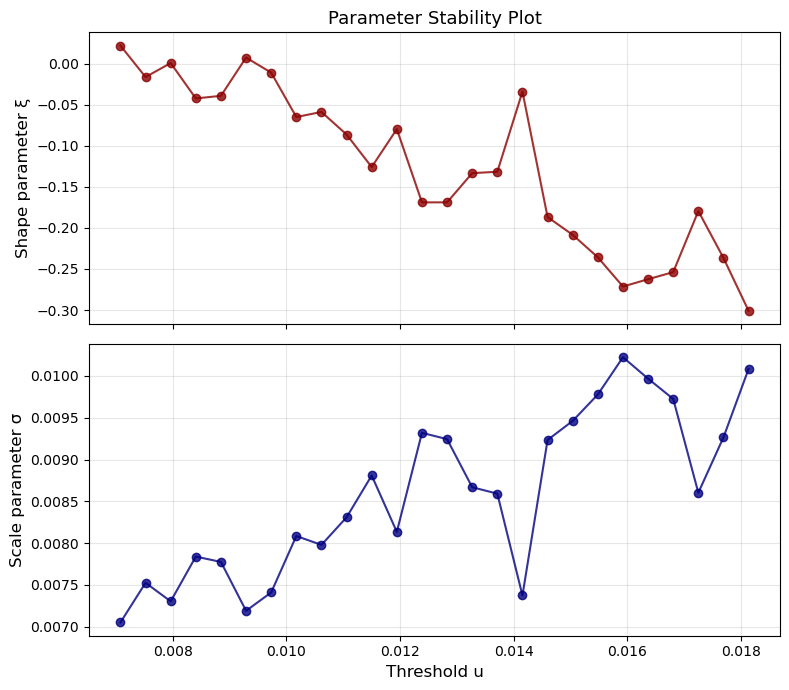

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto

# 1. Define range of candidate thresholds
u_min, u_max = np.percentile(loss, 80), np.percentile(loss, 98)  # typical range 80–98%
thresholds = np.linspace(u_min, u_max, 40)

# 2. Fit GPD via MLE for each threshold
shape_list, scale_list, n_exceed = [], [], []

for u in thresholds:
    exceed = loss[loss > u]
    excess = exceed - u
    n = len(excess)
    if n > 20:  # require at least 20 exceedances
        # Fit GPD (loc=0 so that the threshold is u)
        xi, loc, sigma = genpareto.fit(excess, floc=0)
        shape_list.append(xi)
        scale_list.append(sigma)
        n_exceed.append(n)
    else:
        shape_list.append(np.nan)
        scale_list.append(np.nan)
        n_exceed.append(n)

# 3. Create summary DataFrame
df_stability = pd.DataFrame({
    "u": thresholds,
    "xi": shape_list,
    "sigma": scale_list,
    "n_exceed": n_exceed
})

# 4. Plot parameter stability
fig, ax = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# Shape parameter (ξ)
ax[0].plot(df_stability["u"], df_stability["xi"], 'o-', color='darkred', alpha=0.8)
ax[0].set_ylabel("Shape parameter ξ", fontsize=12)
ax[0].set_title("Parameter Stability Plot", fontsize=13)
ax[0].grid(alpha=0.3)

# Scale parameter (σ)
ax[1].plot(df_stability["u"], df_stability["sigma"], 'o-', color='navy', alpha=0.8)
ax[1].set_xlabel("Threshold u", fontsize=12)
ax[1].set_ylabel("Scale parameter σ", fontsize=12)
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Value-at-Risk

In [169]:
from scipy.stats import genpareto

# 1. Choose a high threshold quantile
threshold_q = 0.9
u = np.quantile(loss, threshold_q)

# 2. Compute exceedances
excess = loss[loss > u] - u

# 3. Count total observations and exceedances
n = len(loss)
n_u = len(excess)
zeta = n_u / n

# 4. Fit GPD
shape_hat, loc_hat, scale_hat = genpareto.fit(excess, floc=0)

print(f"GPD parameters: ξ (shape) = {shape_hat:.4f}, loc = {loc_hat:.4f}, σ̃ (scale) = {scale_hat:.4f}")

# 5. VaR
VaR_pot = u + (scale_hat / shape_hat) * ((p_tail_loss / zeta) ** (-shape_hat) - 1)
print(f"VaR_GPD: {VaR_pot:.6f}")

# 6. Confidence Interval
np.random.seed(123)
n_boot = 1000
VaR_boot = []

for _ in range(n_boot):
    sim_excess = genpareto.rvs(c=shape_hat, loc=0, scale=scale_hat, size=n_u)
    sh, lo, sc = genpareto.fit(sim_excess, floc=0)
    VaR_boot.append(u + (sc / sh) * (((p_tail_loss / zeta) ** (-sh)) - 1))

VaR_boot = np.array(VaR_boot)
VaR_lower, VaR_upper = np.percentile(VaR_boot, [2.5, 97.5])

print(f"95% CI: [{VaR_lower:.6f}, {VaR_upper:.6f}]")

GPD parameters: ξ (shape) = -0.1279, loc = 0.0000, σ̃ (scale) = 0.0088
VaR_GPD: 0.029239
95% CI: [0.024743, 0.033391]


#### Model diagnostics

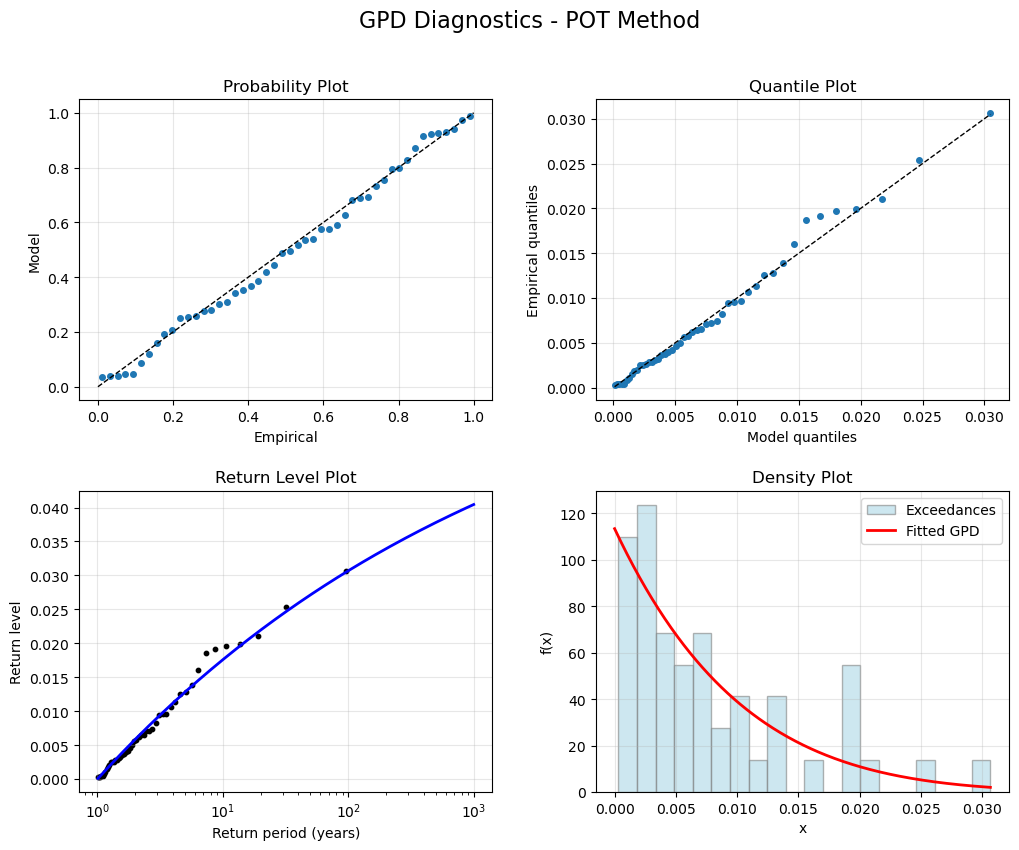

In [171]:
from scipy.stats import genpareto

# 1. Probability plot
empirical_probs = (np.arange(1, len(excess)+1) - 0.5) / len(excess)
sorted_excess = np.sort(excess)
gpd_cdf = genpareto.cdf(sorted_excess, c=shape_hat, loc=0, scale=scale_hat)

# 2. Quantile plot
theoretical_q = genpareto.ppf(empirical_probs, c=shape_hat, loc=0, scale=scale_hat)
empirical_q = sorted_excess

# 3. Return level plot
return_periods = np.logspace(-1, 3, 200)
F = 1 - 1/return_periods
return_levels = genpareto.ppf(F, c=shape_hat, loc=0, scale=scale_hat)

# 4. Density / Histogram
x = np.linspace(0, sorted_excess.max(), 300)
pdf_gpd = genpareto.pdf(x, c=shape_hat, loc=0, scale=scale_hat)

# 5. Graphs
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# --- Probability Plot ---
axs[0, 0].plot(empirical_probs, gpd_cdf, "o", markersize=4, label="Data")
axs[0, 0].plot([0,1], [0,1], "k--", lw=1)
axs[0, 0].set_title("Probability Plot")
axs[0, 0].set_xlabel("Empirical")
axs[0, 0].set_ylabel("Model")
axs[0, 0].grid(alpha=0.3)

# --- Quantile Plot ---
axs[0, 1].plot(theoretical_q, empirical_q, "o", markersize=4)
axs[0, 1].plot([theoretical_q.min(), theoretical_q.max()],
               [theoretical_q.min(), theoretical_q.max()], "k--", lw=1)
axs[0, 1].set_title("Quantile Plot")
axs[0, 1].set_xlabel("Model quantiles")
axs[0, 1].set_ylabel("Empirical quantiles")
axs[0, 1].grid(alpha=0.3)

# --- Return Level Plot ---
axs[1, 0].plot(return_periods, return_levels, "b-", lw=2)
axs[1, 0].scatter(1/ (1 - empirical_probs), sorted_excess, color="black", s=10)
axs[1, 0].set_xscale("log")
axs[1, 0].set_title("Return Level Plot")
axs[1, 0].set_xlabel("Return period (years)")
axs[1, 0].set_ylabel("Return level")
axs[1, 0].grid(alpha=0.3)

# --- Density Plot ---
axs[1, 1].hist(excess, bins=20, density=True, alpha=0.6,
               color="lightblue", edgecolor="gray", label="Exceedances")
axs[1, 1].plot(x, pdf_gpd, "r-", lw=2, label="Fitted GPD")
axs[1, 1].set_title("Density Plot")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("f(x)")
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

plt.suptitle("GPD Diagnostics - POT Method", fontsize=16)
plt.show()

#### Value-at-Risk Filtered

In [174]:
from scipy.stats import genpareto
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 1. Exponential smoothing
smoother = SimpleExpSmoothing(np.abs(ret))
fit_smooth = smoother.fit(smoothing_level=0.05, optimized=False)
vol_smooth = np.maximum(fit_smooth.fittedvalues, 1e-12)

# 2. Filtered losses
z_loss = loss / vol_smooth

# 3. Threshold
u_z = np.quantile(z_loss, threshold_q)
excess_z = z_loss[z_loss > u_z] - u_z
n_z = len(z_loss)
n_u_z = len(excess_z)
zeta_z = n_u_z / n_z

# 4. Fit GPD
xi_z, loc_z, beta_z = genpareto.fit(excess_z, floc=0)
print(f"GPD parameters: ξ_z = {xi_z:.4f}, σ̃_z = {beta_z:.6f}, u_z = {u_z:.6f}, ζ_z = {zeta_z:.4f}")

# 5 VaR
if np.isclose(xi_z, 0.0, atol=1e-8):
    VaR_z = u_z + beta_z * np.log(zeta_z / p_tail_loss)
else:
    VaR_z = u_z + (beta_z / xi_z) * ((p_tail_loss / zeta_z) ** (-xi_z) - 1.0)
sigma_next = vol_smooth[-1]
VaR_pot_FHS = VaR_z * sigma_next

# 6. Confidence Interval
np.random.seed(123)
n_boot = 1000
VaR_boot_z = []

for _ in range(n_boot):
    sim_excess = genpareto.rvs(c=shape_hat_z, loc=0, scale=scale_hat_z, size=n_u)
    sh, lo, sc = genpareto.fit(sim_excess, floc=0)
    if np.isclose(sh, 0.0, atol=1e-8):
        VaR_sim = u_z + sc * np.log(zeta_z / p_tail_loss)
    else:
        VaR_sim = u_z + (sc / sh) * ((p_tail_loss / zeta_z) ** (-sh) - 1)
    VaR_boot_z.append(VaR_sim)

VaR_boot_z = np.array(VaR_boot_z)
VaR_lower_z, VaR_upper_z = np.percentile(VaR_boot_z, [2.5, 97.5])
sigma_next = vol_smooth[-1]
VaR_F = VaR_z * sigma_next
VaR_lower_F = VaR_lower_z * sigma_next
VaR_upper_F = VaR_upper_z * sigma_next

print(f"\nσ_forecast(T+1) = {sigma_next:.6f}")
print(f"VaR_z (Filtered) = {VaR_z:.6f}")
print(f"VaR_GPD_Filtered = {VaR_F:.6f}")
print(f"95% CI: [{VaR_lower_F:.6f}, {VaR_upper_F:.6f}]\n")

GPD parameters: ξ_z = 0.0583, σ̃_z = 0.860067, u_z = 1.407455, ζ_z = 0.0998

σ_forecast(T+1) = 0.006764
VaR_z (Filtered) = 3.524882
VaR_GPD_Filtered = 0.023843
95% CI: [0.017633, 0.022599]



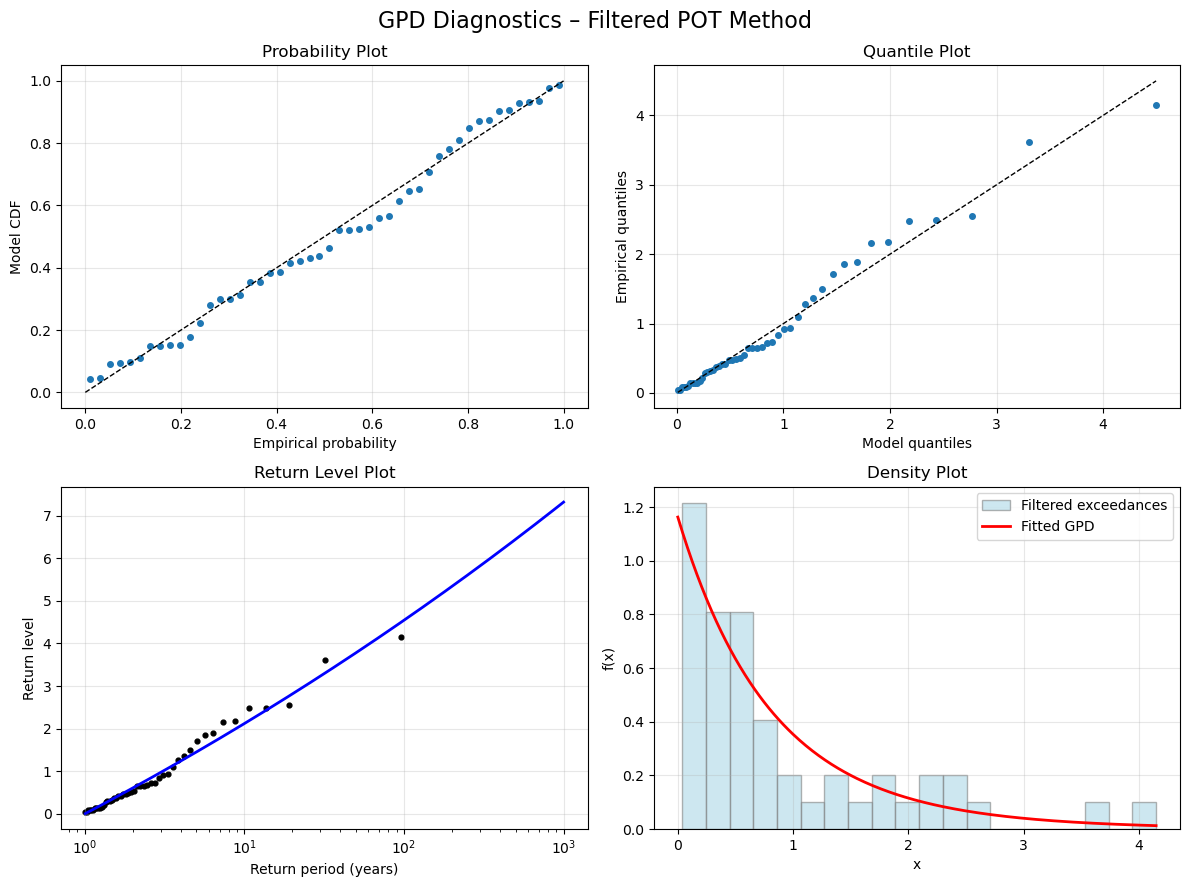

In [115]:
from scipy.stats import genpareto
import numpy as np
import matplotlib.pyplot as plt

excess = excess_z          # exceedances in filtered space
xi = xi_z                  # shape parameter
beta = beta_z              # scale parameter

# 1. Probability Plot
sorted_excess = np.sort(excess)
m = len(sorted_excess)

empirical_probs = (np.arange(1, m+1) - 0.5) / m
gpd_cdf = genpareto.cdf(sorted_excess, c=xi, loc=0, scale=beta)

# 2. Quantile Plot
theoretical_q = genpareto.ppf(empirical_probs, c=xi, loc=0, scale=beta)
empirical_q = sorted_excess

# 3. Return Level Plot (EXCEEDANCES)
return_periods = np.logspace(-1, 3, 200)
F = 1 - 1 / return_periods
return_levels = genpareto.ppf(F, c=xi, loc=0, scale=beta)

empirical_return_periods = 1 / (1 - empirical_probs)

# 4. Density / Histogram
x = np.linspace(0, sorted_excess.max(), 300)
pdf_gpd = genpareto.pdf(x, c=xi, loc=0, scale=beta)

# 5. DIAGNOSTIC PLOTS
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# --- Probability Plot ---
axs[0, 0].plot(empirical_probs, gpd_cdf, "o", markersize=4)
axs[0, 0].plot([0, 1], [0, 1], "k--", lw=1)
axs[0, 0].set_title("Probability Plot")
axs[0, 0].set_xlabel("Empirical probability")
axs[0, 0].set_ylabel("Model CDF")
axs[0, 0].grid(alpha=0.3)

# --- Quantile Plot ---
axs[0, 1].plot(theoretical_q, empirical_q, "o", markersize=4)
axs[0, 1].plot([theoretical_q.min(), theoretical_q.max()],
               [theoretical_q.min(), theoretical_q.max()],
               "k--", lw=1)
axs[0, 1].set_title("Quantile Plot")
axs[0, 1].set_xlabel("Model quantiles")
axs[0, 1].set_ylabel("Empirical quantiles")
axs[0, 1].grid(alpha=0.3)

# --- Return Level Plot ---
axs[1, 0].plot(return_periods, return_levels, "b-", lw=2,
               label="GPD model (filtered)")
axs[1, 0].scatter(empirical_return_periods, sorted_excess,
                  color="black", s=12, label="Empirical")
axs[1, 0].set_xscale("log")
axs[1, 0].set_title("Return Level Plot")
axs[1, 0].set_xlabel("Return period (years)")
axs[1, 0].set_ylabel("Return level")
axs[1, 0].grid(alpha=0.3)

# --- Density Plot ---
axs[1, 1].hist(excess, bins=20, density=True,
               alpha=0.6, color="lightblue",
               edgecolor="gray", label="Filtered exceedances")
axs[1, 1].plot(x, pdf_gpd, "r-", lw=2, label="Fitted GPD")
axs[1, 1].set_title("Density Plot")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("f(x)")
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

plt.suptitle("GPD Diagnostics – Filtered POT Method", fontsize=16)
plt.tight_layout()
plt.show()

## 4. Time series

### 4.1. Filtered Time series

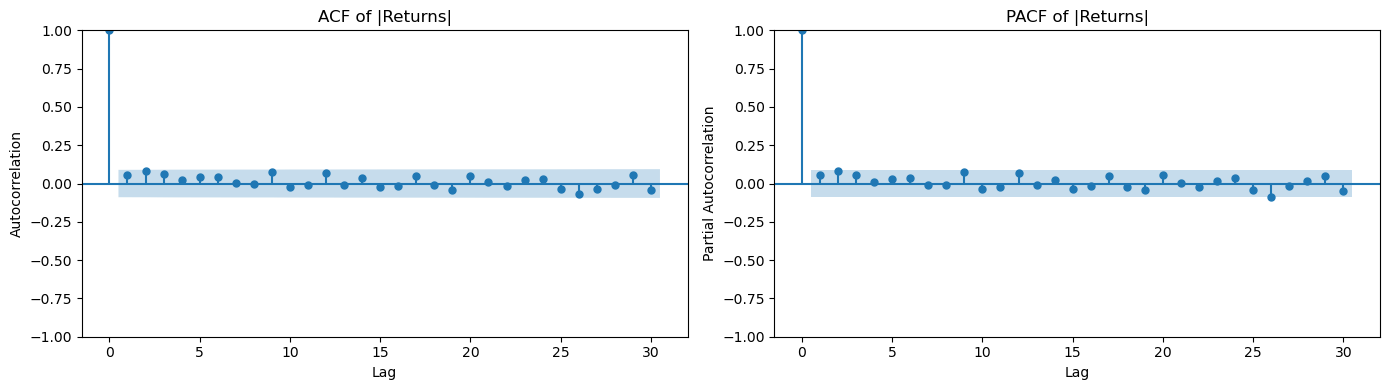

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

abs_ret = np.abs(ret)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF
plot_acf(abs_ret, lags=30, ax=axes[0])
axes[0].set_title("ACF of |Returns|", fontsize=12)
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

# PACF
plot_pacf(abs_ret, lags=30, ax=axes[1], method="ywm")
axes[1].set_title("PACF of |Returns|", fontsize=12)
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

#### Value-at-Risk

Quantile of filtered residuals = 3.646913
Forecast σ(T+1) = 0.006764
VaR_Filtered = 0.024669

95% CI for VaR_Filtered: [0.018414, 0.026672]



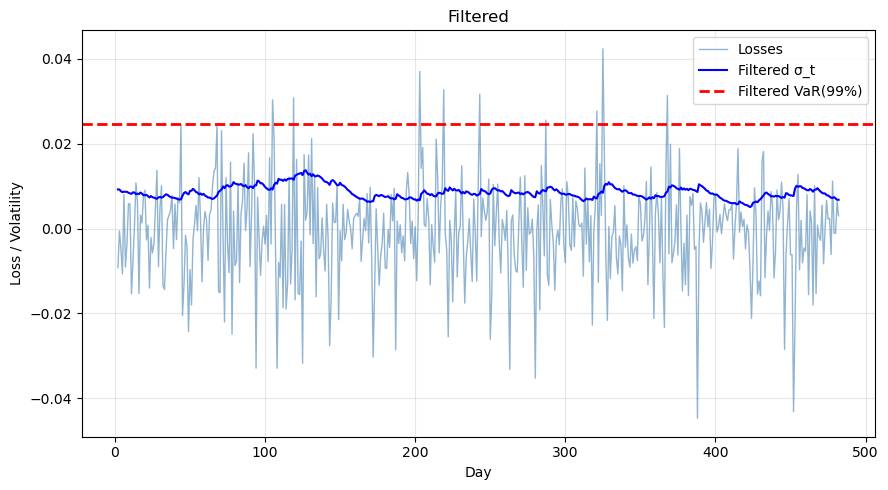

In [135]:
# 1. Estimate local volatility (exponential smoothing of abs returns)
smoother = SimpleExpSmoothing(np.abs(ret))
fit_smooth = smoother.fit(smoothing_level=0.05, optimized=False)
vol_smooth = fit_smooth.fittedvalues  # numpy array

# 2. Filtered time serie
z = -ret / vol_smooth

# 3. Quantile of filtered residuals
VaR_z = np.quantile(z, 1-alpha_ret)
print(f"Quantile of filtered residuals = {VaR_z:.6f}")

# 4. forecast next volatility (use last smoothed σ)
sigma_next = vol_smooth[-1]
mu_next = 0  # assume zero conditional mean
print(f"Forecast σ(T+1) = {sigma_next:.6f}")

# 5. VaR
VaR_Filtered = mu_next + VaR_z * sigma_next
print(f"VaR_Filtered = {VaR_Filtered:.6f}\n")

# 6. Confidence Interval - BETA
sorted_z = np.sort(z)
n = len(sorted_z)
alpha = alpha_loss

# order statistic index for VaR_z
k = int(np.floor((alpha) * n))

# confidence interval for cumulative probability
p_lower = beta.ppf(0.025, k, n + 1 - k)
p_upper = beta.ppf(0.975, k, n + 1 - k)

# transform back to quantile space
VaR_z_lower = np.quantile(sorted_z, p_lower)
VaR_z_upper = np.quantile(sorted_z, p_upper)

# scale by σ(T+1)
VaR_Filtered_lower = VaR_z_lower * sigma_next
VaR_Filtered_upper = VaR_z_upper * sigma_next

print(f"95% CI for VaR_Filtered: [{VaR_Filtered_lower:.6f}, {VaR_Filtered_upper:.6f}]\n")

# 7. Graph
plt.figure(figsize=(9, 5))
plt.plot(df_daily["day"], loss, color="steelblue", lw=1, alpha=0.6, label="Losses")
plt.plot(df_daily["day"], vol_smooth, color="blue", lw=1.5, label="Filtered σ_t")
plt.axhline(VaR_Filtered, color="red", linestyle="--", lw=2, label=f"Filtered VaR({alpha_loss*100:.0f}%)")
plt.title("Filtered")
plt.xlabel("Day")
plt.ylabel("Loss / Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### ACF Filtered serie

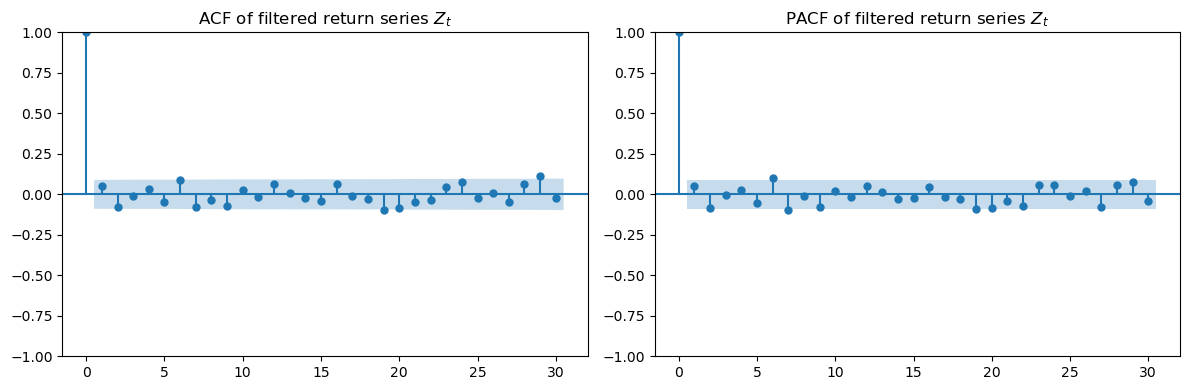

In [121]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12,4))

plot_acf(z, lags=30, ax=ax[0])
ax[0].set_title("ACF of filtered return series $Z_t$")

plot_pacf(z, lags=30, ax=ax[1])
ax[1].set_title("PACF of filtered return series $Z_t$")

plt.tight_layout()
plt.show()
sorted_z = np.sort(z)
n = len(sorted_z)
alpha = alpha_ret

#### Empirical CDF Filtered serie

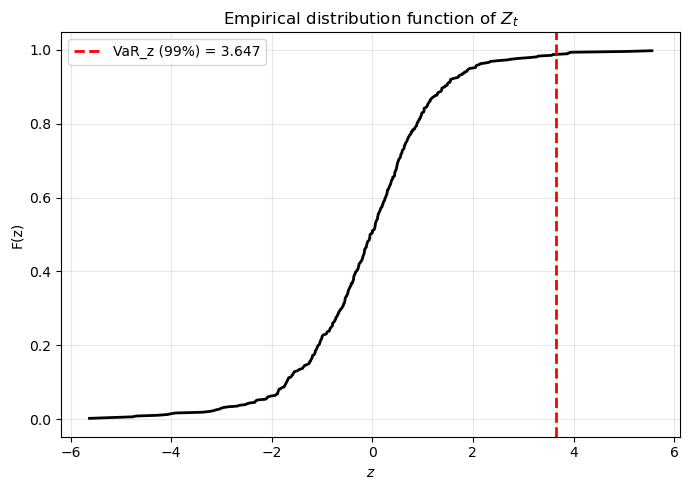

In [123]:
sorted_z = np.sort(z)
n = len(sorted_z)
ecdf = np.arange(1, n+1) / (n+1)

VaR_z = np.quantile(z, alpha_loss)

plt.figure(figsize=(7, 5))
plt.plot(sorted_z, ecdf, color="black", lw=2)
plt.axvline(VaR_z, color="red", linestyle="--", lw=2,
            label=f"VaR_z ({alpha_loss*100:.0f}%) = {VaR_z:.3f}")
plt.title("Empirical distribution function of $Z_t$")
plt.xlabel("$z$")
plt.ylabel("F(z)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Empirical CDF of returns

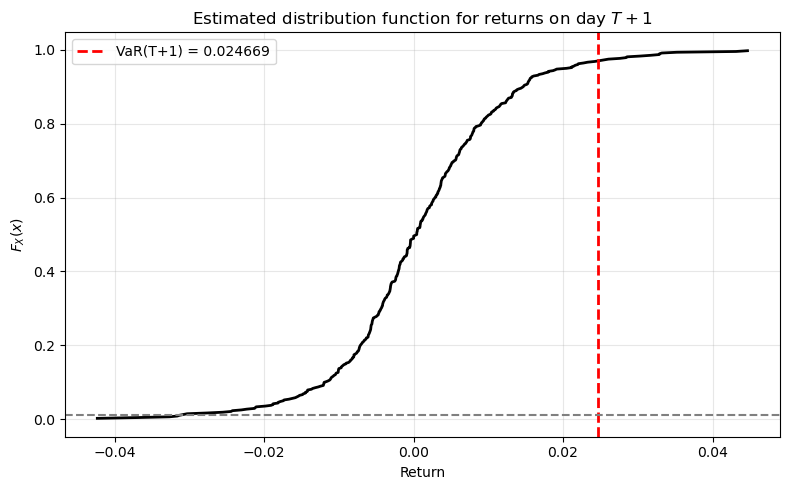

In [125]:
ret_sorted = np.sort(ret)
n = len(ret_sorted)
ecdf_ret = np.arange(1, n+1) / (n+1)
VaR_Filtered
plt.figure(figsize=(8,5))
plt.plot(ret_sorted, ecdf_ret, color='black', lw=2)
plt.axvline(VaR_Filtered, color='red', linestyle='--', lw=2,
            label=f"VaR(T+1) = {VaR_Filtered:.6f}")
plt.axhline(alpha_ret, color='gray', linestyle='--')
plt.title("Estimated distribution function for returns on day $T+1$")
plt.xlabel("Return")
plt.ylabel("$F_X(x)$")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2. GARCH(1,1)

### Value-at-Risk

Estimated parameters (μ = 0):
omega = 0.290802
alpha = 0.036720
beta  = 0.741583

σ_(T+1) = 0.010786
VaR_GARCH (1%) = 0.025092
IC 95% VaR_GARCH = [0.023601, 0.026784]


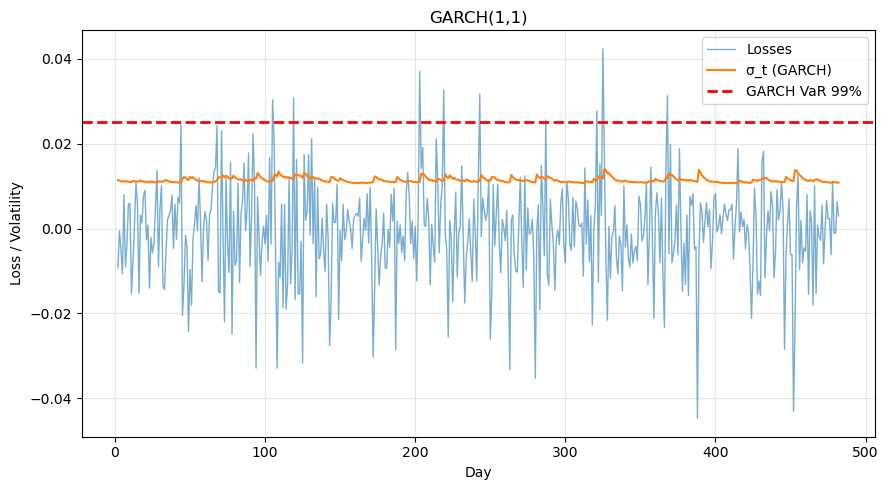

In [127]:
from scipy.stats import norm, chi2
from scipy.optimize import minimize

# Losses instead of returns
loss = -ret
loss_scaled = 100 * loss    # scale
n = len(loss_scaled)

# 1. GARCH(1,1) WITH FIXED mu = 0
def garch_loglik_no_mu(params, data):
    omega, alpha, beta = params

    if omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1:
        return 1e10

    n_local = len(data)
    eps = data   # mu = 0 → eps = loss

    sigma2 = np.zeros(n_local)
    sigma2[0] = np.var(data)

    for t in range(1, n_local):
        sigma2[t] = omega + alpha * eps[t-1]**2 + beta * sigma2[t-1]

    ll = -0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + eps**2 / sigma2)
    return -ll

# 2. Estimate (ω, α, β)
omega0, alpha0, beta0 = 0.1, 0.05, 0.9
x0 = np.array([omega0, alpha0, beta0])

bounds = [(1e-8,None), (0,1), (0,1)]

res = minimize(garch_loglik_no_mu, x0, args=(loss_scaled,), bounds=bounds)
omega, alpha_g, beta_g = res.x

print("Estimated parameters (μ = 0):")
print(f"omega = {omega:.6f}")
print(f"alpha = {alpha_g:.6f}")
print(f"beta  = {beta_g:.6f}")

# 3. Rebuild sigma_t
eps = loss_scaled
sigma2 = np.zeros(n)
sigma2[0] = np.var(loss_scaled)

for t in range(1, n):
    sigma2[t] = omega + alpha_g * eps[t-1]**2 + beta_g * sigma2[t-1]

sigma_t = np.sqrt(sigma2)

# 4. One-step-ahead forecast
sigma_next = np.sqrt(omega + alpha_g * eps[-1]**2 + beta_g * sigma2[-1])
sigma_next_real = sigma_next / 100
print(f"\nσ_(T+1) = {sigma_next_real:.6f}")

# 5. VaR for LOSSES 
z_alpha = norm.ppf(alpha_ret)    # negative (e.g., -2.33)
VaR_GARCH = - z_alpha * sigma_next / 100   # POSITIVE VaR
print(f"VaR_GARCH (1%) = {VaR_GARCH:.6f}")

# 6. Confidence Interval for VaR
gamma = 0.05
sigma_lower = sigma_next * np.sqrt(n / chi2.ppf(1-gamma/2, n))
sigma_upper = sigma_next * np.sqrt(n / chi2.ppf(gamma/2, n))

VaR_lower = - z_alpha * sigma_lower / 100
VaR_upper = - z_alpha * sigma_upper / 100

print(f"95% CI VaR_GARCH = [{VaR_lower:.6f}, {VaR_upper:.6f}]")

# 7. Graph
plt.figure(figsize=(9,5))
plt.plot(df_daily["day"], loss, lw=1, alpha=0.6, label="Losses")
plt.plot(df_daily["day"], sigma_t/100, lw=1.5, label="σ_t (GARCH)")
plt.axhline(VaR_GARCH, color="red", linestyle="--", lw=2,
            label=f"GARCH VaR 99%")

plt.title("GARCH(1,1)")
plt.xlabel("Day")
plt.ylabel("Loss / Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Garch and stochastic volatility models

## 3.1. Simulated Data

Rate 1: omega=0.00000, alpha=0.12240, beta=0.87760, alpha+beta=1.00000
Rate 5: omega=0.00000, alpha=0.17491, beta=0.81978, alpha+beta=0.99469
Rate 10: omega=0.00000, alpha=0.22222, beta=0.76633, alpha+beta=0.98855
Rate 50: omega=0.00000, alpha=0.28350, beta=0.71556, alpha+beta=0.99905
Rate 100: omega=0.00000, alpha=0.42333, beta=0.57538, alpha+beta=0.99871


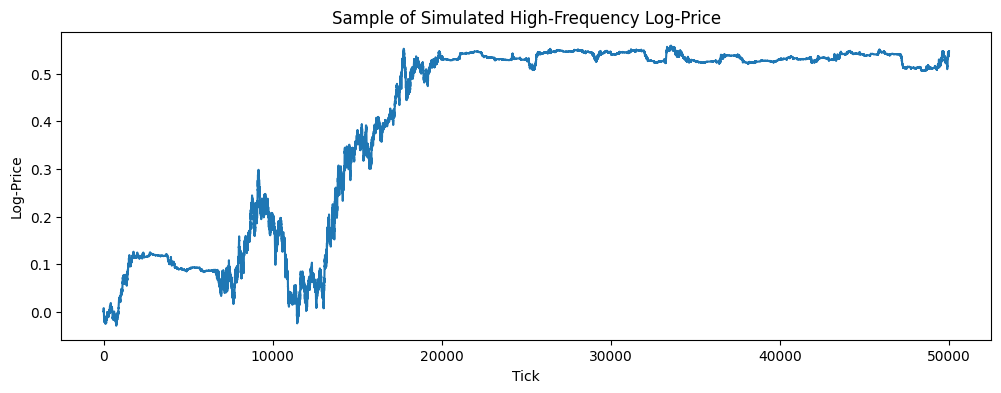

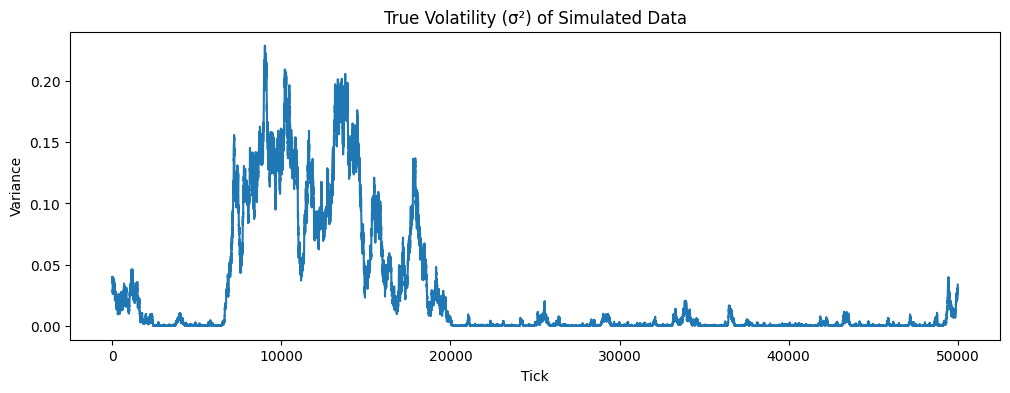

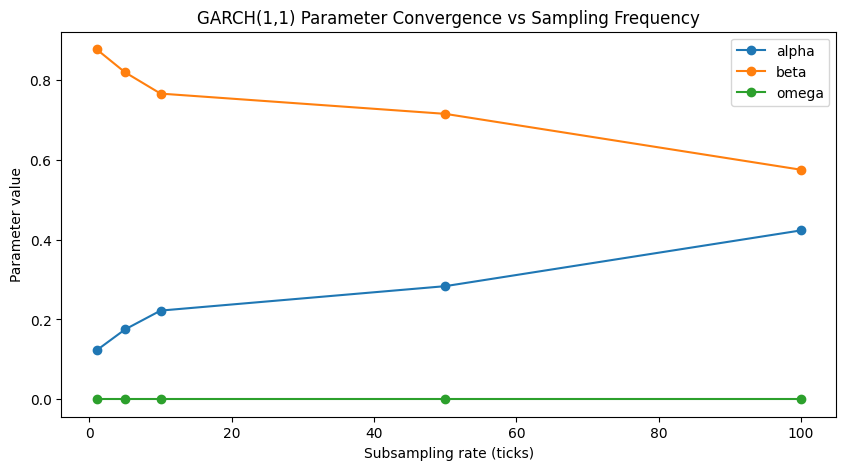

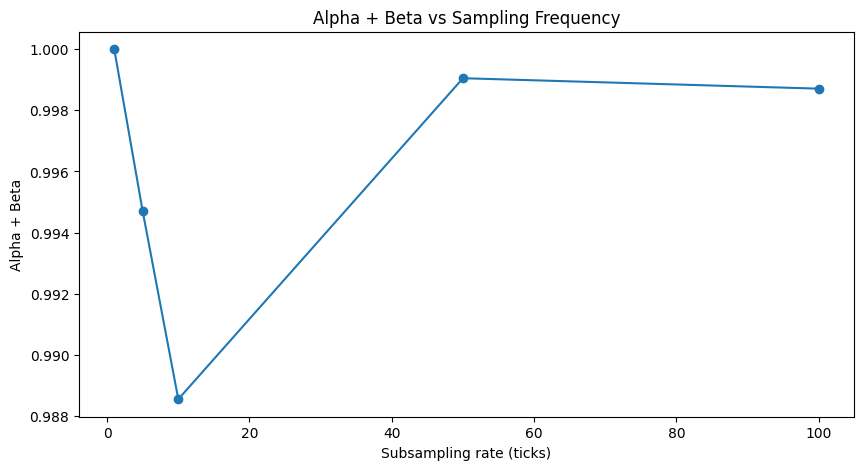

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(42) #seed for reproducibility

#  1. PARAMETERS
omega0 = 0.02
beta0  = 1.5
alpha0 = 0.3

D = 10                 # number of days
ticks_per_day = 10000  # ~100k lines total
n = D * ticks_per_day
dt = 1.0 / ticks_per_day

#  2. SIMULATE STOCHASTIC VOLATILITY DIFFUSION
X = np.zeros(n)
sigma2 = np.zeros(n)
X[0] = 0.0
sigma2[0] = 0.04  # initial variance

dB1 = np.sqrt(dt) * np.random.randn(n)
dB2 = np.sqrt(dt) * np.random.randn(n)

for i in range(1, n):
    sigma2[i] = sigma2[i-1] + (omega0 - beta0*sigma2[i-1])*dt + np.sqrt(2*alpha0*sigma2[i-1])*dB2[i]
    if sigma2[i] < 0:
        sigma2[i] = 1e-7
    X[i] = X[i-1] + np.sqrt(sigma2[i]) * dB1[i]

#  3. CREATE DATAFRAME
df = pd.DataFrame({
    "day": np.repeat(np.arange(D), ticks_per_day),
    "tick": np.tile(np.arange(ticks_per_day), D),
    "logprice": X
})

#  4. RETURNS
returns = df["logprice"].diff().dropna().values

#  5. GARCH(1,1) FUNCTIONS
def garch11_loglik(params, returns):
    omega, alpha, beta = params
    if omega <= 0 or alpha < 0 or beta < 0 or (alpha+beta >= 1):
        return 1e10
    T = len(returns)
    var = np.zeros(T)
    var[0] = np.var(returns)
    for t in range(1, T):
        var[t] = omega + alpha*returns[t-1]**2 + beta*var[t-1]
        if var[t] <= 0:
            return 1e10
    loglik = 0.5 * np.sum(np.log(2*np.pi*var) + returns**2 / var)
    return loglik

def fit_garch11(returns):
    x0 = np.array([1e-6, 0.05, 0.90])
    bounds = [(1e-12,None), (1e-12,1-1e-12), (1e-12,1-1e-12)]
    res = minimize(garch11_loglik, x0, args=(returns,), bounds=bounds, method="L-BFGS-B")
    omega_hat, alpha_hat, beta_hat = res.x
    return omega_hat, alpha_hat, beta_hat

#  6.SUBSAMPLING AND PARAMETER CONVERGENCE
subsample_rates = [1, 5, 10, 50, 100]  # ticks to skip
omega_list = []
alpha_list = []
beta_list = []

for rate in subsample_rates:
    sub_returns = returns[::rate]  # subsample every 'rate' ticks
    omega_hat, alpha_hat, beta_hat = fit_garch11(sub_returns)
    omega_list.append(omega_hat)
    alpha_list.append(alpha_hat)
    beta_list.append(beta_hat)
    print(f"Rate {rate}: omega={omega_hat:.5f}, alpha={alpha_hat:.5f}, beta={beta_hat:.5f}, alpha+beta={alpha_hat+beta_hat:.5f}")

#  7. PLOT PARAMETER CONVERGENCE
plt.figure(figsize=(12,4))
plt.plot(df["logprice"][:50000])
plt.title("Sample of Simulated High-Frequency Log-Price")
plt.xlabel("Tick")
plt.ylabel("Log-Price")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(sigma2[:50000])
plt.title("True Volatility (σ²) of Simulated Data")
plt.xlabel("Tick")
plt.ylabel("Variance")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(subsample_rates, alpha_list, marker='o', label="alpha")
plt.plot(subsample_rates, beta_list, marker='o', label="beta")
plt.plot(subsample_rates, omega_list, marker='o', label="omega")
plt.title("GARCH(1,1) Parameter Convergence vs Sampling Frequency")
plt.xlabel("Subsampling rate (ticks)")
plt.ylabel("Parameter value")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(subsample_rates, np.array(alpha_list)+np.array(beta_list), marker='o')
plt.title("Alpha + Beta vs Sampling Frequency")
plt.xlabel("Subsampling rate (ticks)")
plt.ylabel("Alpha + Beta")
plt.show()

## 3.2. Real Data

   day      tick  logprice
0    1  0.000726  2.905808
1    1  0.000769  2.905260
2    1  0.000855  2.905808
3    1  0.000897  2.905260
4    1  0.000940  2.906354
Rate 1: omega=0.00000, alpha=0.02642, beta=0.47551, alpha+beta=0.50192
Rate 5: omega=0.00000, alpha=0.23312, beta=0.58679, alpha+beta=0.81991
Rate 10: omega=0.00000, alpha=0.09794, beta=0.51602, alpha+beta=0.61397
Rate 50: omega=0.00000, alpha=0.16092, beta=0.50466, alpha+beta=0.66557
Rate 100: omega=0.00000, alpha=0.02631, beta=0.47350, alpha+beta=0.49980


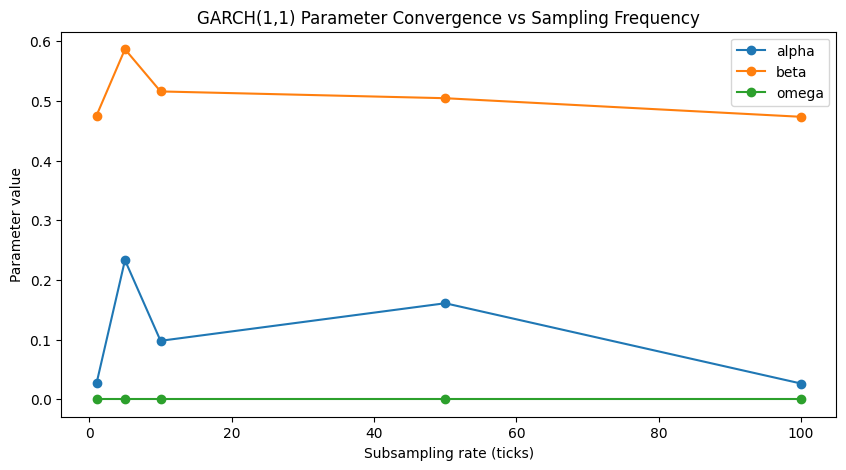

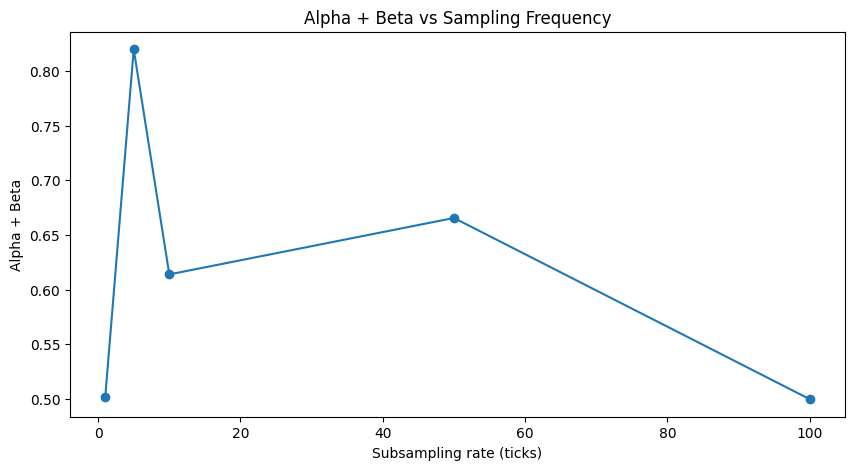

In [ ]:
# 1. Upload data
df = pd.read_csv("out23.csv")

# 2. Visualisation
print(df.head())

# 3. Compute log-returns
returns = df["logprice"].diff().dropna().values

subsample_rates = [1, 5, 10, 50, 100]  # ticks to skip
omega_list = []
alpha_list = []
beta_list = []

for rate in subsample_rates:
    sub_returns = returns[::rate]
    omega_hat, alpha_hat, beta_hat = fit_garch11(sub_returns)
    omega_list.append(omega_hat)
    alpha_list.append(alpha_hat)
    beta_list.append(beta_hat)
    print(f"Rate {rate}: omega={omega_hat:.5f}, alpha={alpha_hat:.5f}, beta={beta_hat:.5f}, alpha+beta={alpha_hat+beta_hat:.5f}")

#4. Graph
plt.figure(figsize=(10,5))
plt.plot(subsample_rates, alpha_list, marker='o', label="alpha")
plt.plot(subsample_rates, beta_list, marker='o', label="beta")
plt.plot(subsample_rates, omega_list, marker='o', label="omega")
plt.title("GARCH(1,1) Parameter Convergence vs Sampling Frequency")
plt.xlabel("Subsampling rate (ticks)")
plt.ylabel("Parameter value")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(subsample_rates, np.array(alpha_list)+np.array(beta_list), marker='o')
plt.title("Alpha + Beta vs Sampling Frequency")
plt.xlabel("Subsampling rate (ticks)")
plt.ylabel("Alpha + Beta")
plt.show()

## 3.3. VaR

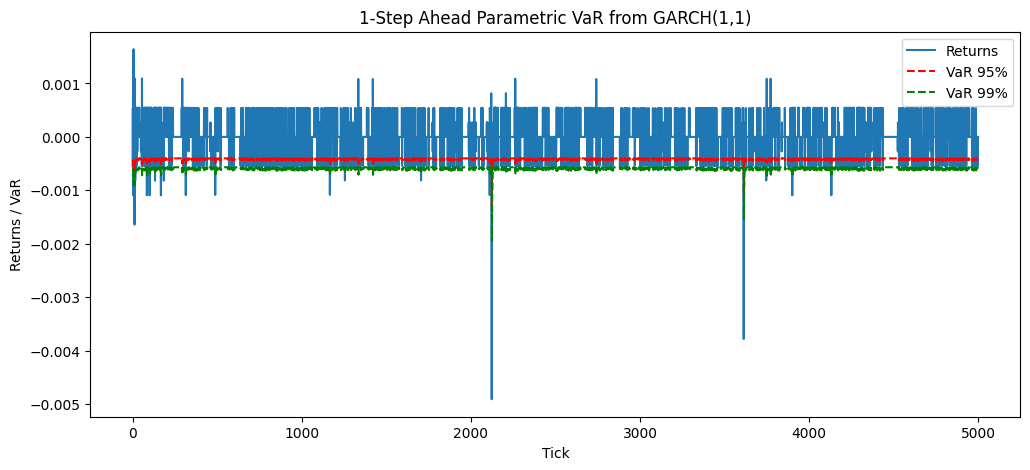

Example VaR values:
[-0.00060251 -0.00062122 -0.00062992 -0.00063401 -0.00073043]


In [ ]:
from scipy.stats import norm

# 1. step ahead conditional variance from GARCH(1,1)
T = len(returns)
garch_var = np.zeros(T)
garch_var[0] = np.var(returns)  # initialize
omega_hat, alpha_hat, beta_hat = fit_garch11(returns)

for t in range(1, T):
    garch_var[t] = omega_hat + alpha_hat * returns[t-1]**2 + beta_hat * garch_var[t-1]

# 2. VaR at 95% confidence
q = 0.95
z_q = norm.ppf(q)  # 1.645
VaR_95 = z_q * np.sqrt(garch_var)

# 3. VaR at 99% confidence
q2 = 0.99
z_q2 = norm.ppf(q2)  # 2.33
VaR_99 = z_q2 * np.sqrt(garch_var)

# 4. Plot VaR vs returns
plt.figure(figsize=(12,5))
plt.plot(returns[:5000], label="Returns")
plt.plot(-VaR_95[:5000], 'r--', label="VaR 95%")
plt.plot(-VaR_99[:5000], 'g--', label="VaR 99%")
plt.title("1-Step Ahead Parametric VaR from GARCH(1,1)")
plt.xlabel("Tick")
plt.ylabel("Returns / VaR")
plt.legend()
plt.show()

alpha_VaR = 0.99  # confidence level
z_alpha = np.abs(np.quantile(np.random.randn(10_00000), 1 - alpha_VaR))

# One-step-ahead VaR series
var_series = - np.sqrt(garch_var) * z_alpha   # minus sign: VaR is a loss threshold

# Print example
print("Example VaR values:")
print(var_series[:5])

## 3.4. Garch(p,q)

In [ ]:
# This section of the code takes 6 hours approximatively to run. But all the results are indicated in the appendix G.4 of the report.

# GENERALIZED GARCH(p,q) FUNCTIONS & CRITERIA

def garch_pq_loglik(params, returns, p, q):
    """Calculates the Log-Likelihood for a GARCH(p,q) model."""

    # params structure: [omega, alpha_1, ..., alpha_p, beta_1, ..., beta_q]
    omega = params[0]
    alphas = params[1 : 1 + p]
    betas = params[1 + p : 1 + p + q]

    T = len(returns)

    # 1. Constraints Check
    if omega <= 0 or np.any(alphas < 0) or np.any(betas < 0) or np.sum(alphas) + np.sum(betas) >= 1:
        return 1e10

    # 2. Initialization
    max_lag = max(p, q)
    initial_var = np.var(returns)
    var = np.full(T, initial_var)

    # 3. Conditional Variance Loop
    for t in range(max_lag, T):
      arch_term = np.sum(alphas * returns[t - p : t][::-1]**2)
      garch_term = np.sum(betas * var[t - q : t][::-1])
      var[t] = omega + arch_term + garch_term

      if var[t] <= 0:
          return 1e10

    # 4. Log-Likelihood Calculation
    loglik = 0.5 * np.sum(np.log(2 * np.pi * var[max_lag:]) + returns[max_lag:]**2 / var[max_lag:])

    return loglik

def fit_garch_pq(returns, p, q):
    """Fits the GARCH(p,q) model using MLE."""

    k = 1 + p + q

    # Setup Initial Guesses (x0) and Bounds
    x0 = np.array([1e-6] + [0.8 / (p + q)] * p + [0.1 / (p + q)] * q)
    bounds = [(1e-12, None)] * 1 + [(1e-12, 1.0)] * (p + q)

    res = minimize(garch_pq_loglik, x0, args=(returns, p, q), bounds=bounds, method="L-BFGS-B")

    max_logL = -res.fun

    return res.x, max_logL

def calculate_criteria(max_logL, k, n):
    """Calculates AIC, BIC, and AICC."""

    AIC = -2 * max_logL + 2 * k
    BIC = -2 * max_logL + np.log(n) * k

    if n - k - 1 > 0:
        AICC = AIC + (2 * k * (k + 1)) / (n - k - 1)
    else:
        AICC = np.inf

    return AIC, BIC, AICC

# REAL DATA LOADING AND MODEL SELECTION

print("\n--- GARCH Model Selection on Real Data ---")

# Load Real Data
try:
    df_real = pd.read_csv("out23.csv")
except FileNotFoundError:
    print("Error: out23.csv not found. Cannot proceed with real data analysis.")
    exit()

# Compute log-returns for REAL data
real_returns = df_real["logprice"].diff().dropna().values
T_real = len(real_returns)

models_to_test = {
    "GARCH(1,1)": (1, 1),
    "GARCH(1,2)": (1, 2),
    "GARCH(2,1)": (2, 1)
}

results = {}

print(f"Total observations (N) for model selection: {T_real}")
print("--------------------------------------------------------------------")

for name, (p, q) in models_to_test.items():
    k = 1 + p + q
    print(f"Fitting {name} (k={k})...")

    # Fitting the model using the generalized function and REAL data
    try:
        params, max_logL = fit_garch_pq(real_returns, p, q)
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        continue

    # Calculate criteria
    AIC, BIC, AICC = calculate_criteria(max_logL, k, T_real)

    results[name] = {
        'params': params,
        'LogL': max_logL,
        'k': k,
        'AIC': AIC,
        'BIC': BIC,
        'AICC': AICC
    }

    # Print results
    print(f"  Max Log-L: {max_logL:.2f}")
    # Print parameters with their labels (omega, alpha, beta)
    param_labels = ["omega"] + [f"alpha_{i+1}" for i in range(p)] + [f"beta_{i+1}" for i in range(q)]
    param_output = ", ".join([f"{label}={p_val:.6f}" for label, p_val in zip(param_labels, params)])
    print(f"  Parameters: {param_output}")
    print(f"  AIC: {AIC:.4f}, BIC: {BIC:.4f}, AICC: {AICC:.4f}\n")

# DETERMINE OPTIMAL MODEL
print("Model Selection Summary (Lowest Score is Optimal):")
print("---------------------------------------")

if results:
    models = list(results.keys())

    # Create a DataFrame for easy viewing
    comparison_df = pd.DataFrame({
        'Model': models,
        'LogL': [results[m]['LogL'] for m in models],
        'k': [results[m]['k'] for m in models],
        'AIC': [results[m]['AIC'] for m in models],
        'BIC': [results[m]['BIC'] for m in models],
        'AICC': [results[m]['AICC'] for m in models]
    }).set_index('Model')

    # Highlight the best model for each criterion
    best_aic_model = comparison_df['AIC'].idxmin()
    best_bic_model = comparison_df['BIC'].idxmin()

    print(comparison_df.sort_values(by='BIC'))

    print(f"\nOptimal Model by AIC: {best_aic_model}")
    print(f"Optimal Model by BIC: {best_bic_model}")


--- GARCH Model Selection on Real Data ---
Total observations (N) for model selection: 1721979
--------------------------------------------------------------------
Fitting GARCH(1,1) (k=3)...
  Max Log-L: 11828718.54
  Parameters: omega=0.000000, alpha_1=0.465494, beta_1=0.452962
  AIC: -23657431.0867, BIC: -23657394.0098, AICC: -23657431.0867

Fitting GARCH(1,2) (k=4)...
  Max Log-L: 11791815.81
  Parameters: omega=0.000000, alpha_1=0.017497, beta_1=0.002187, beta_2=0.002187
  AIC: -23583623.6273, BIC: -23583574.1914, AICC: -23583623.6273

Fitting GARCH(2,1) (k=4)...
  Max Log-L: -6451593.04
  Parameters: omega=0.000000, alpha_1=0.179060, alpha_2=0.179060, beta_1=0.166482
  AIC: 12903194.0751, BIC: 12903243.5110, AICC: 12903194.0751

Model Selection Summary (Lowest Score is Optimal):
---------------------------------------
                    LogL  k           AIC           BIC          AICC
Model                                                                
GARCH(1,1)  1.182872e+0